<a href="https://colab.research.google.com/github/Zypperman/DBTT_G1_GRP3/blob/prelim_EDA/Notebooks/Usecase_0_0_V1(EDA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA + Code adaptation

Data obtained from [Kaggle](https://www.kaggle.com/datasets/ajay1735/hmeq-data) -- Home Equity (HMEQ) dataset for Loan Defaulter Prediction.

----
##### Content obtained from link above
----
## About Dataset
**Context**  
The consumer credit department of a bank wants to automate the decision-making process for approval of home equity lines of credit. To do this, they will follow the recommendations of the Equal Credit Opportunity Act to create an empirically derived and statistically sound credit scoring model. The model will be based on data collected from recent applicants granted credit through the current process of loan underwriting. The model will be built from predictive modeling tools, but the created model must be sufficiently interpretable to provide a reason for any adverse actions (rejections).

**Content**  
The Home Equity dataset (HMEQ) contains baseline and loan performance information for 5,960 recent home equity loans. The target (BAD) is a binary variable indicating whether an applicant eventually defaulted or was seriously delinquent. This adverse outcome occurred in 1,189 cases (20%). For each applicant, 12 input variables were recorded.

The data set HMEQ reports characteristics and delinquency information for 5,960 home equity loans. A home equity loan is a loan where the obligor uses the equity of his or her home as the underlying collateral. The data set has the following characteristics:

**Data Dictionary**

| Variable | Description | Data Type |
|------------|------------|------------|
| BAD        | 1 = applicant defaulted on loan or seriously delinquent;<br> 0 = applicant paid loan | Binary Nominal (Target Variable)  |
| LOAN       | Amount of the loan request                                                                      | Ratio-Scaled Numeric      |
| MORTDUE    | Amount due on existing mortgage                                                                 | Ratio-Scaled Numeric      |
| VALUE      | Value of current property                                                                      | Ratio-Scaled Numeric      |
| REASON     | DebtCon = debt consolidation; <br>HomeImp = home improvement                                        | Nominal                   |
| JOB        | Occupational categories                                                                         | Nominal                   |
| YOJ        | Years at present job                                                                           | Numeric                   |
| DEROG      | Number of major derogatory reports                                                              | Numeric                   |
| DELINQ     | Number of delinquent credit lines                                                               | Numeric                   |
| CLAGE      | Age of oldest credit line in months                                                             | Numeric                   |
| NINQ       | Number of recent credit inquiries                                                               | Numeric                   |
| CLNO       | Number of credit lines                                                                          | Numeric                   |
| DEBTINC    | Debt-to-income ratio| Ratio-Scaled Numeric      |

----

## Translations and Assumptions

For the Krungsri Katalyst Analytic Dashboard, we make the following assumptions:  
- The bank already has a data lake and approximations of the data used in this analysis, either obtained from the loan applications, or compiled from information it already has about each applicant based on existing accounts and lines of credit.
- The data required for this model will be updated at frequent intervals, and larger volumes will be used for training in order to provide more robust predictions. For this, a data-pipeline needs to first be built by data engineers.
- For the future incorporation of time-series data modelled after the economic state, there also needs to be a robust data-pipeline of both leading and lagging economic indicators provided. This will be supplemented by economists and related personnel by the bank who can make quantitative predictions and provide relevant statistics that are outside the scope of our expertise as consultants.





In [1]:
!pip install kagglehub
!pip install kagglehub[pandas-datasets]
!pip install scikit-learn

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.naive_bayes import GaussianNB
import statsmodels.api as sm
from scipy.stats import probplot
from sklearn import metrics
from sklearn import preprocessing
from sklearn import utils
from sklearn.metrics import mean_absolute_error
from statistics import mean, stdev
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, cross_val_score, cross_validate, StratifiedKFold
from sklearn.svm import SVC
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

In [3]:
from genericpath import exists
# kaggle api key, please use your own to download the data
KAGGLE_USERNAME = 'zypperman'
KAGGLE_KEY = '084281dba0d0e6614a17ee1d7284235d'
DATA_FILEPATH = './kaggle/working/'

import kagglehub
from kagglehub import KaggleDatasetAdapter
import os

file_path =  'hmeq.csv' # referring to filepath in data source

# Set the Kaggle API credentials
os.environ['KAGGLE_USERNAME'] = KAGGLE_USERNAME
os.environ['KAGGLE_KEY'] = KAGGLE_KEY

# Load the latest version
data = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "ajay1735/hmeq-data",
  file_path,
)
# save raw data locally
os.makedirs(DATA_FILEPATH,exist_ok=True)
data.to_csv(DATA_FILEPATH+'hmeq.csv')

100%|██████████| 394k/394k [00:00<00:00, 2.78MB/s]


## Intro remarks
- dataset seems to be on US clients, given the policy mentioned for where this data was obtained from (Equal Credit Opportunity Act)

## Basic Data exploration

First, we will assess the nature of the data we are dealing with.

In [4]:
print("sample of 5 records:")
data.sample(n=5).head()

sample of 5 records:


,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
625,0,7800,38506.0,50309.0,DebtCon,Other,11.0,0.0,0.0,231.001195,0.0,32.0,35.906116
5869,0,52800,53532.0,68305.0,DebtCon,Office,11.0,0.0,0.0,91.133225,1.0,25.0,40.669687
3882,1,20300,77325.0,133075.0,DebtCon,Office,19.0,1.0,0.0,166.126089,4.0,21.0,40.736022
1229,0,10100,126358.0,180305.0,DebtCon,Other,8.0,0.0,0.0,199.350530,1.0,20.0,32.033629
67,0,3600,100693.0,114743.0,HomeImp,Office,6.0,0.0,0.0,88.470452,0.0,14.0,29.393543


Next, we will assess 3 elements to the data:
1. the number of rows there are
2. the specific name, data-type and number of null values we are dealing with
3. some basic statistics describing the data
  
These can be obtained using some simple methods.

In [5]:
print(f"The Data has {data.shape[0]} rows and {data.shape[1]} columns.")
print("-"*35,"DATA INFO","-"*35,'\n')
print(data.info)
print("-"*35,"BASIC STATS","-"*35,'\n')
print(data.describe())

The Data has 5960 rows and 13 columns.
----------------------------------- DATA INFO ----------------------------------- 

<bound method DataFrame.info of       BAD   LOAN  MORTDUE     VALUE   REASON     JOB   YOJ  DEROG  DELINQ  \
0       1   1100  25860.0   39025.0  HomeImp   Other  10.5    0.0     0.0   
1       1   1300  70053.0   68400.0  HomeImp   Other   7.0    0.0     2.0   
2       1   1500  13500.0   16700.0  HomeImp   Other   4.0    0.0     0.0   
3       1   1500      NaN       NaN      NaN     NaN   NaN    NaN     NaN   
4       0   1700  97800.0  112000.0  HomeImp  Office   3.0    0.0     0.0   
...   ...    ...      ...       ...      ...     ...   ...    ...     ...   
5955    0  88900  57264.0   90185.0  DebtCon   Other  16.0    0.0     0.0   
5956    0  89000  54576.0   92937.0  DebtCon   Other  16.0    0.0     0.0   
5957    0  89200  54045.0   92924.0  DebtCon   Other  15.0    0.0     0.0   
5958    0  89800  50370.0   91861.0  DebtCon   Other  14.0    0.0     0.0  

# Handling outliers , missing values and visualising data


We initialize the background for our visualisations:

In [6]:
sns.set(style="whitegrid")
# plt.style.use('white')
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
colormap = sns.diverging_palette(220, 10, as_cmap=True)

Visualising missing rows in our data:

<ipython-input-7-ac01e6db7e14>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_empty_row_freq['percentage_incomplete'] = dataset_empty_row_freq['incomplete_rows'] / data.shape[0] * 100


The columns with missing values are: "MORTDUE", "VALUE", "REASON", "JOB", "YOJ", "DEROG", "DELINQ", "CLAGE", "NINQ", "CLNO", "DEBTINC"

Missing Data:

         incomplete_rows  percentage_incomplete
MORTDUE              518               8.691275
VALUE                112               1.879195
REASON               252               4.228188
JOB                  279               4.681208
YOJ                  515               8.640940
DEROG                708              11.879195
DELINQ               580               9.731544
CLAGE                308               5.167785
NINQ                 510               8.557047
CLNO                 222               3.724832
DEBTINC             1267              21.258389

Total number of missing cells: 5271, and 6.803% of the data is missing.


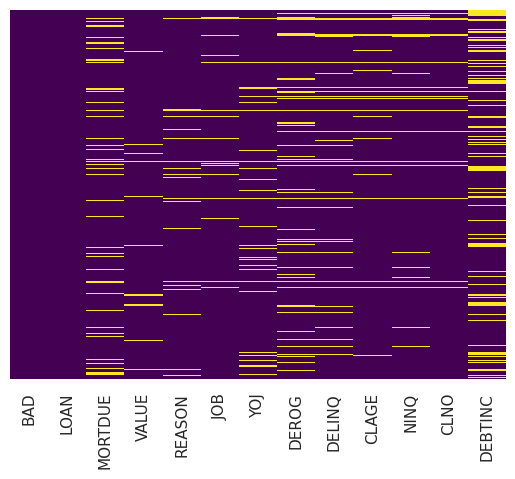

In [7]:
sns.heatmap(data.isnull(),cbar=False,yticklabels=False,cmap = 'viridis')

has_null = round(data.count() / data.shape[0],2) != 1 #condition assigned to variable
dataset_empty_columns = data.columns[has_null]

# get rows with empty datasets
dataset_empty_row_freq = pd.DataFrame([])
dataset_empty_row_freq['incomplete_rows'] = data.shape[0] - data.count()
# remove rows with no missing values
dataset_empty_row_freq = dataset_empty_row_freq[dataset_empty_row_freq['incomplete_rows'] > 0]

dataset_empty_row_freq['percentage_incomplete'] = dataset_empty_row_freq['incomplete_rows'] / data.shape[0] * 100

if missing_cells := sum(dataset_empty_row_freq['incomplete_rows']):

    print("The columns with missing values are:", ", ".join("\"" + i + "\"" for i in dataset_empty_columns))

    print()
    print("Missing Data:")
    print()
    print(dataset_empty_row_freq)
    print()

    percentage_missing_data = (missing_cells / (data.shape[0] * data.shape[1])) * 100
    print(f"Total number of missing cells: {missing_cells}, and {round(percentage_missing_data,3)}% of the data is missing.")

else:
    print("There are no missing values in the dataset.")

we will impute the missing data on the following bases:
1. For the column `REASON`, theres no definite trend to impute this data with existing reasons, hence we will make do with the label `other reason`.
2. For the column `JOB`, the value `Other` seems logical semantically on top of being the modal value for this column, hence we will impute with the modal label `Other`.
3. For the column `DEROG`, we can impute the missing values with the modal value which appears to be `0`.
4. For the column `DELINQ`, we can impute the missing values with the modal value which appears to be `0`.|

As for the remaining fields, there is no basis for imputing the data, nor is there any basis for removing them since each row is still valid, thus we will retain all rows that contain missing numeric data after data-imputation.

In [8]:
data[['JOB',"DEROG",'DELINQ']].mode()

,JOB,DEROG,DELINQ
0,Other,0.0,0.0


modes for columns 'JOB','DEROG','DELINQ':
     JOB  DEROG  DELINQ
0  Other    0.0     0.0
Reviewing the results of data imputation:


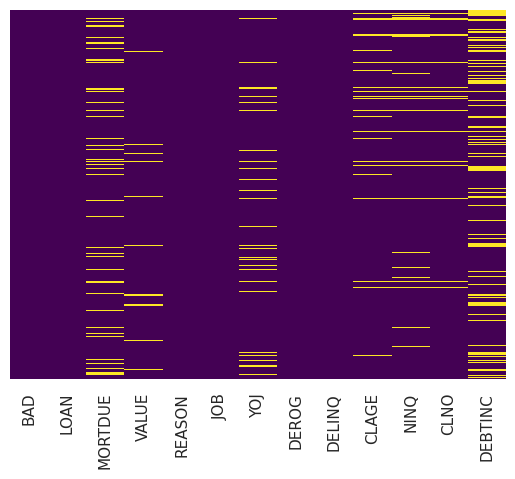

In [9]:
print("modes for columns 'JOB','DEROG','DELINQ':")
print(data[['JOB',"DEROG",'DELINQ']].mode())


data.fillna(
    {
        'REASON':'Other reason',
        "JOB":data['JOB'].mode()[0],
        "DEROG":data['DEROG'].mode()[0],
        "DELINQ":data['DELINQ'].mode()[0]
    }
    ,inplace=True)

print('Reviewing the results of data imputation:')
sns.heatmap(data.isnull(),cbar=False,yticklabels=False,cmap = 'viridis')
plt.show()

For the columns `JOB` and `REASON`, we will perform one-hot encoding.

In [10]:
data = data.join(pd.get_dummies(data["JOB"]))
data = data.join(pd.get_dummies(data["REASON"]))
data.drop(["JOB","REASON"],axis=1,inplace=True)

# Data Visualisation

First, we will take a box plot of all the data to observe if there are any strong outliers:

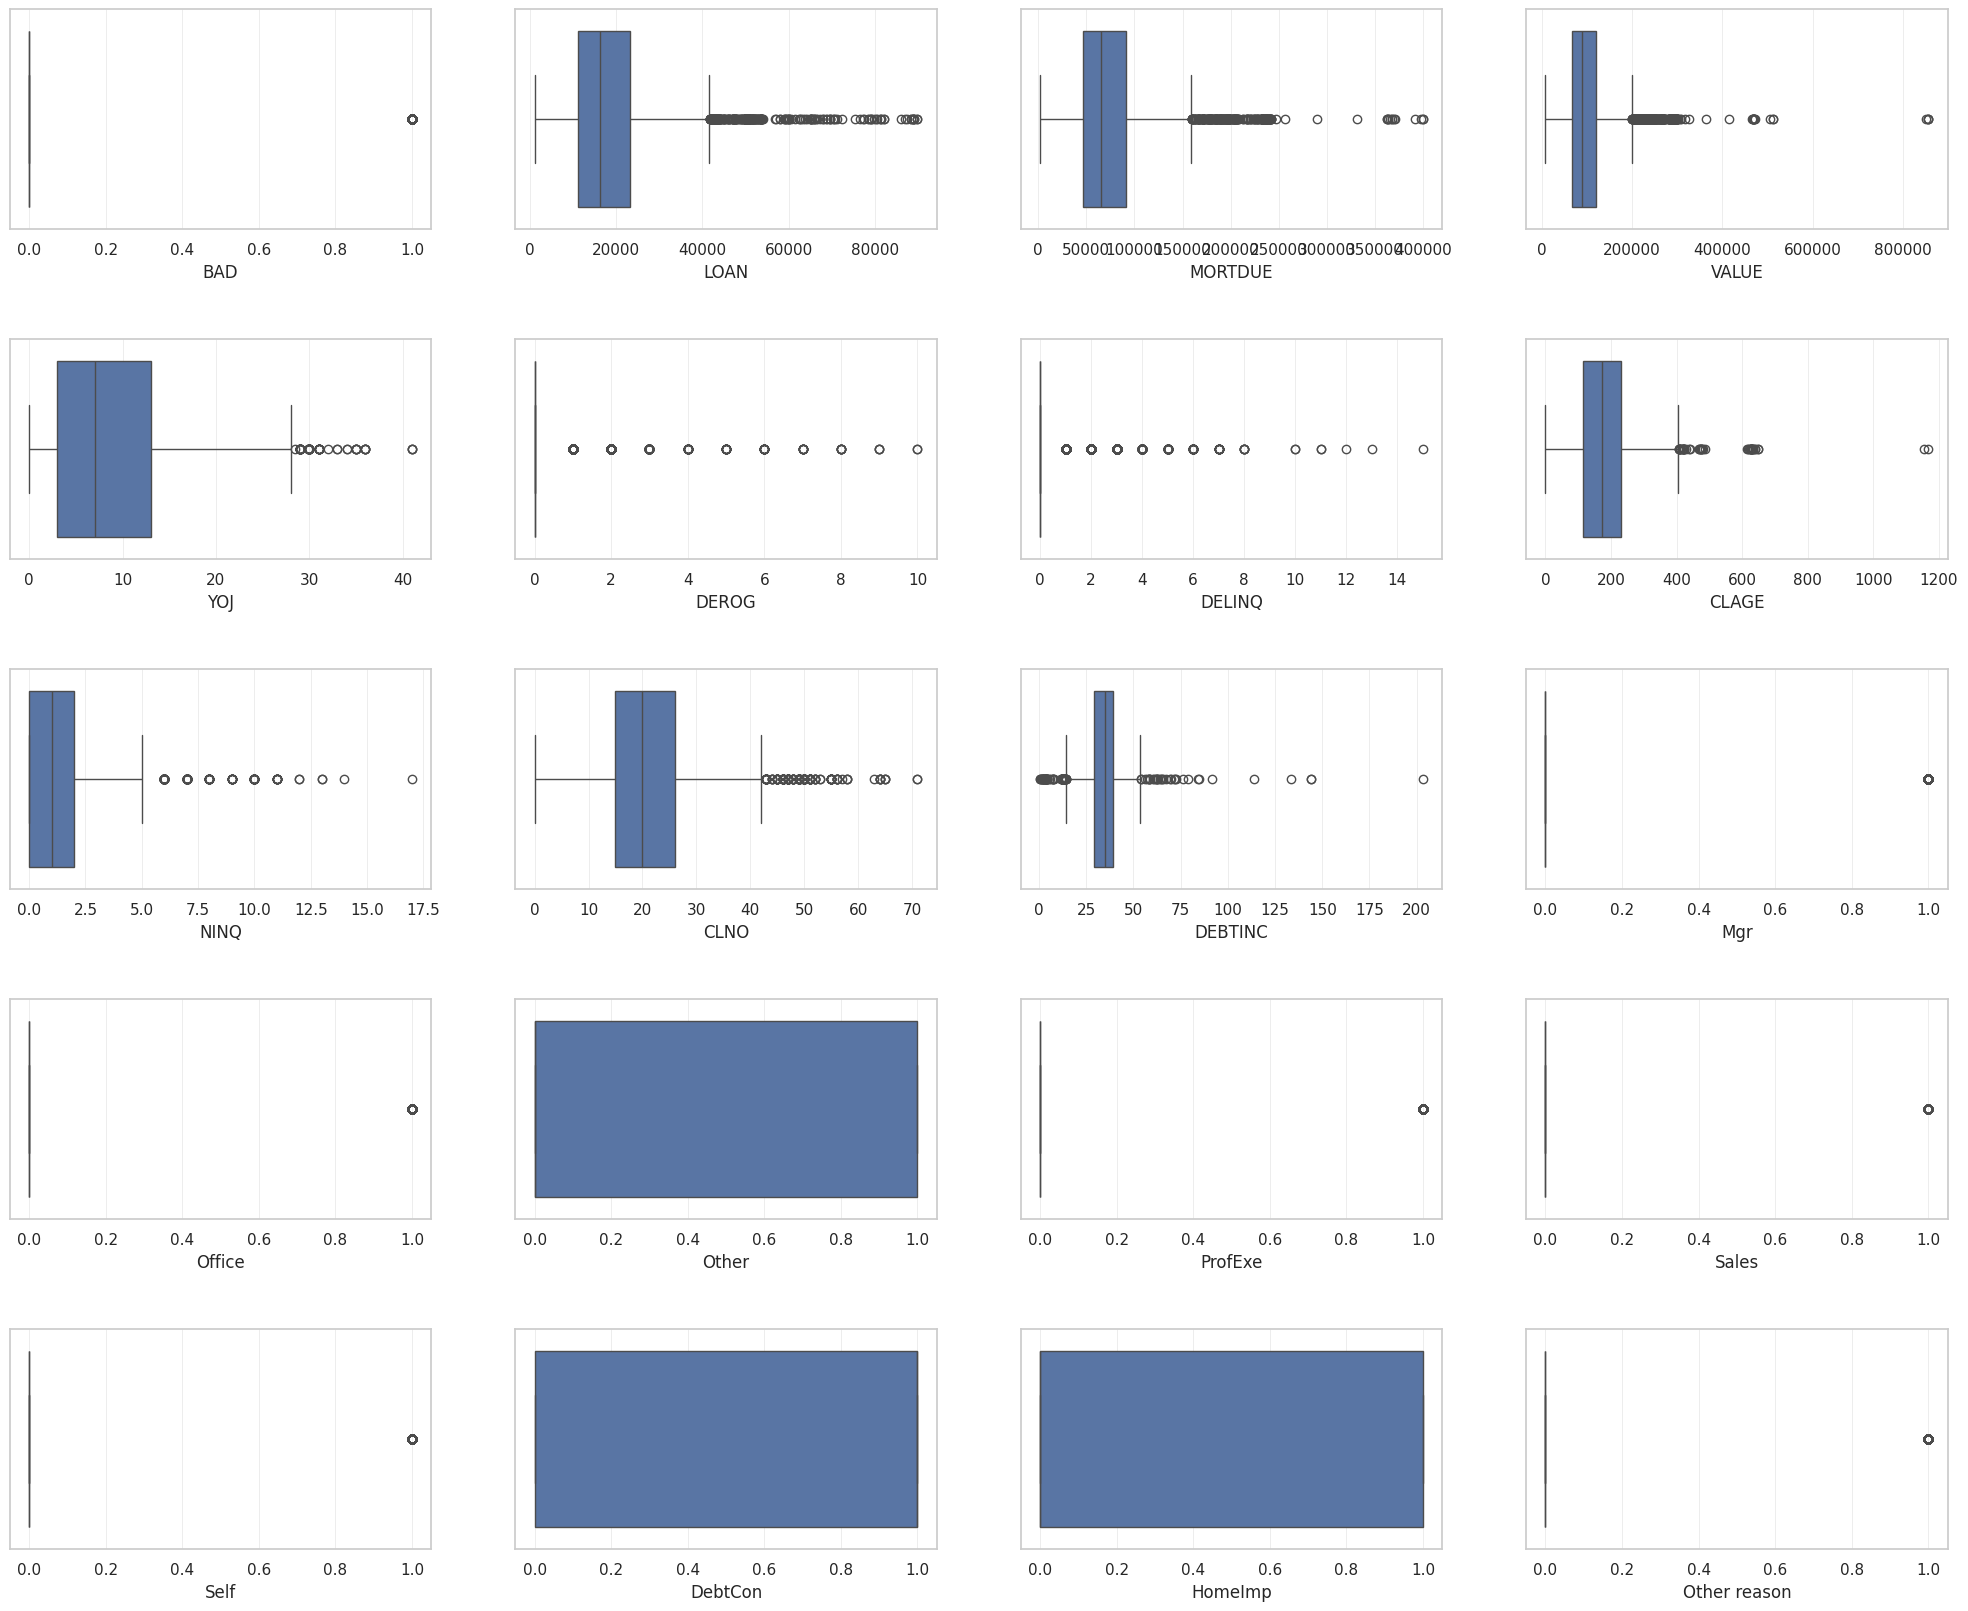

In [11]:
fig, axes = plt.subplots(5, 4, figsize=(25, 20),)
for i,ax in zip(data.columns,axes.flat):
    sns.boxplot(data=data, x=i,ax=ax)     # we can also use violin plot
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

We will also plot the histograms for the respective data to observe if they follow a reasonable normal distribution.

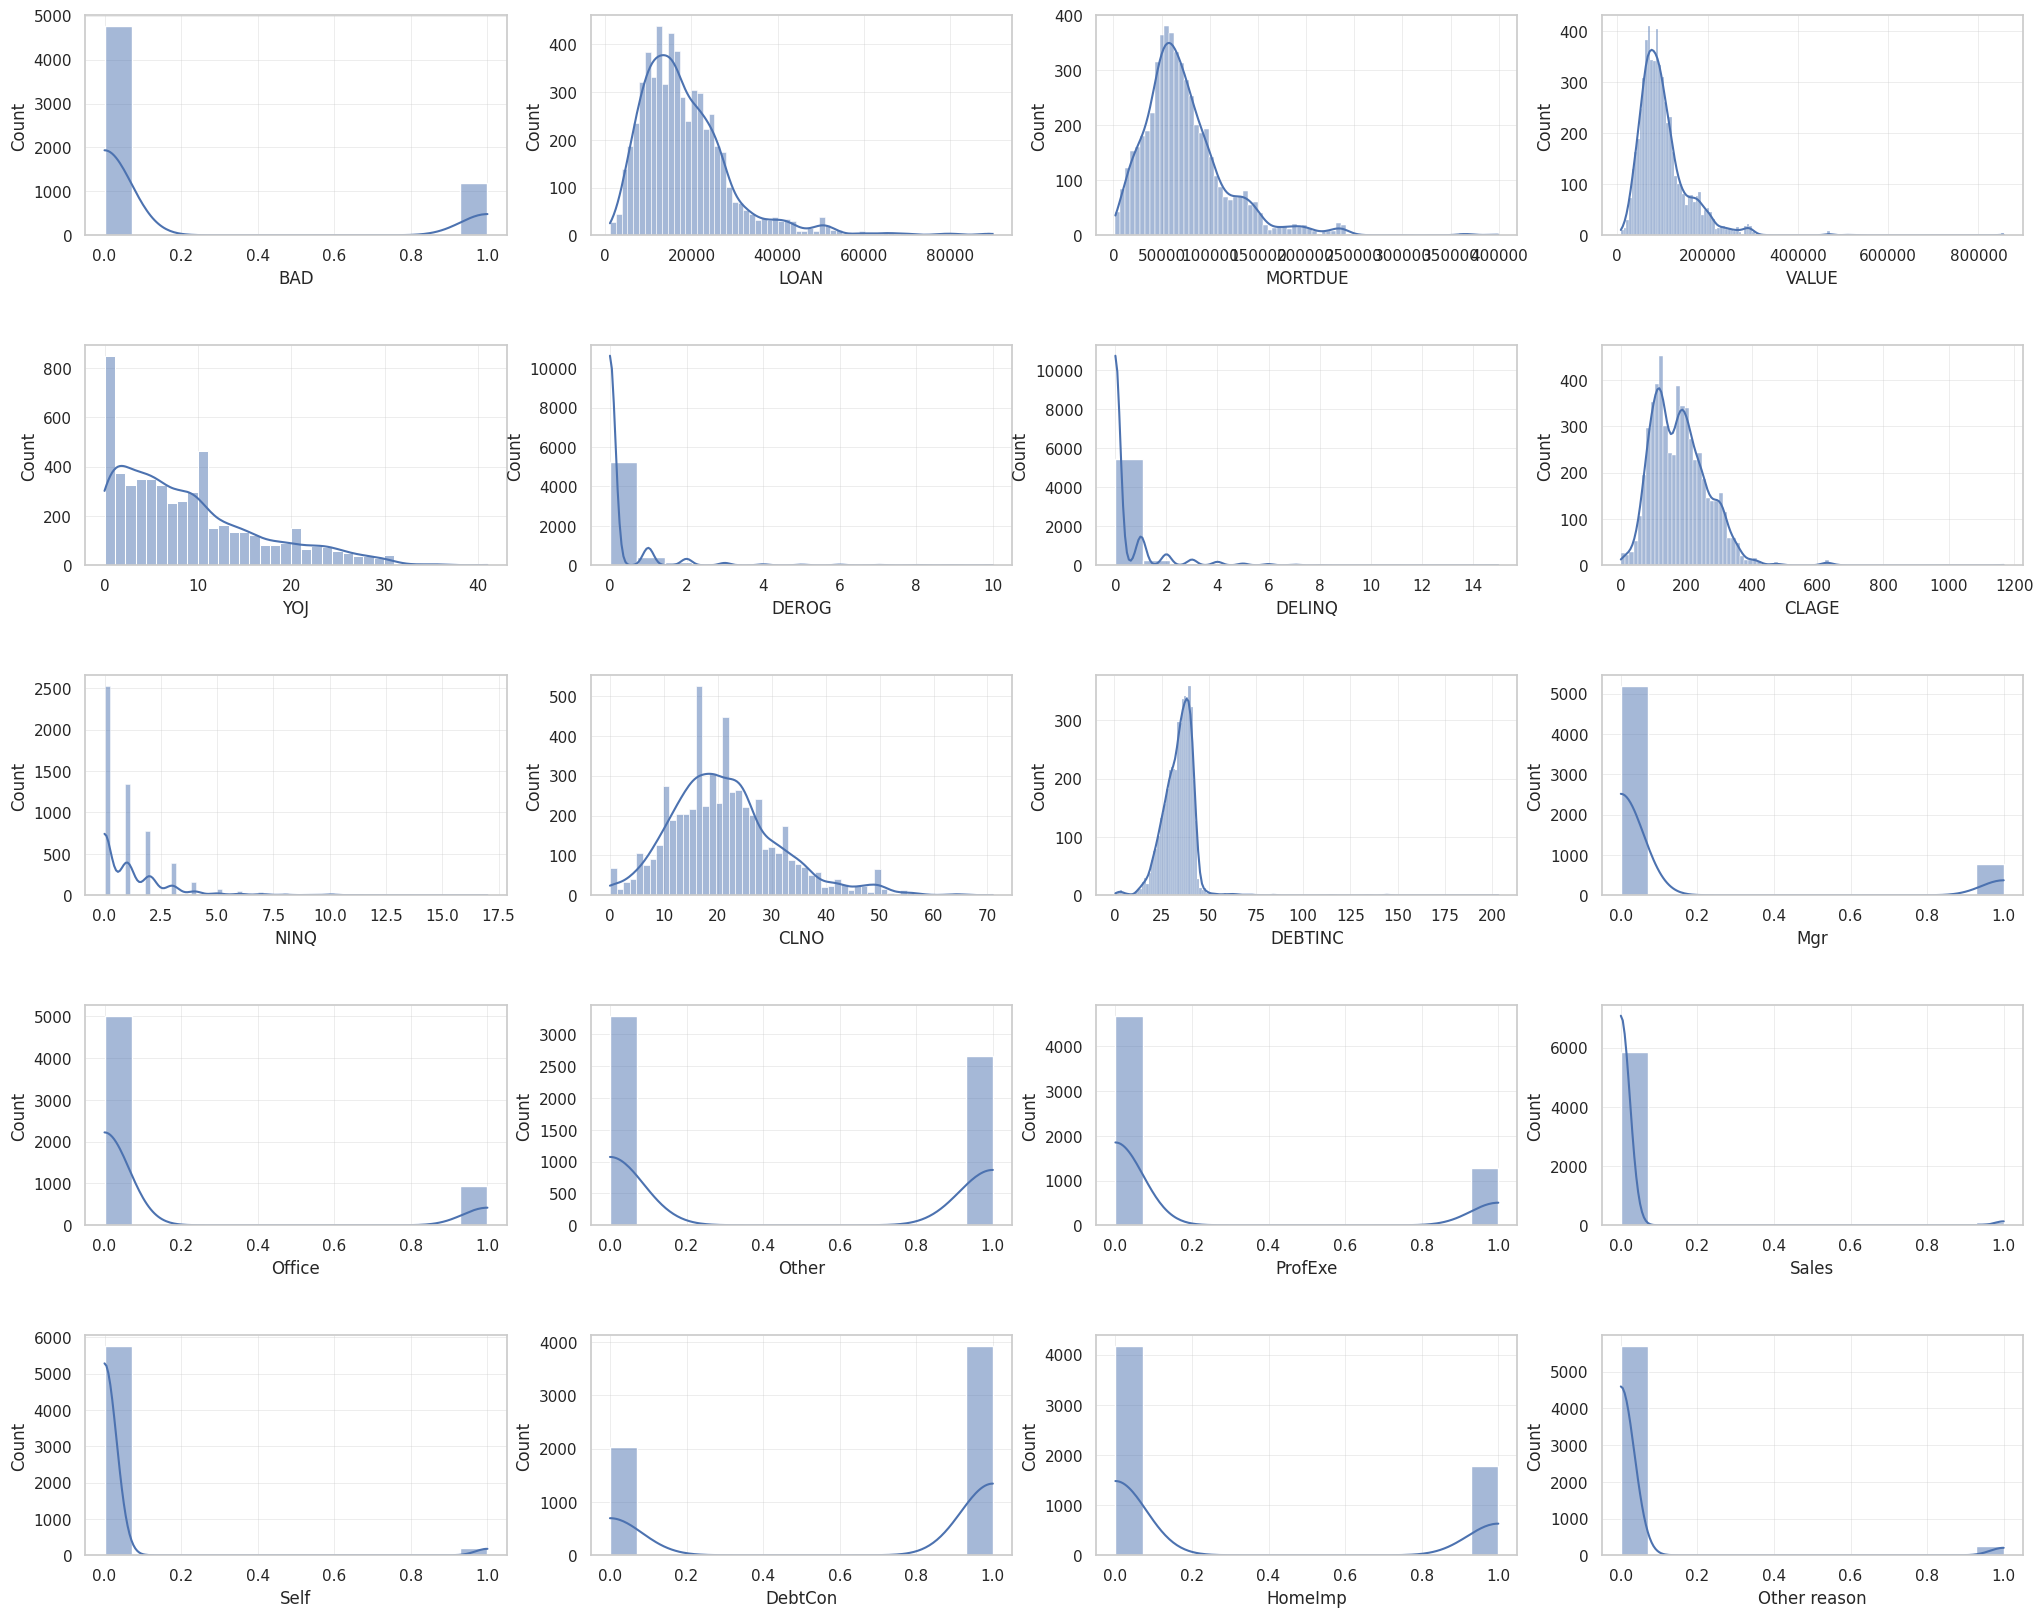

In [12]:
fig, axes = plt.subplots(5, 4, figsize=(25, 20))
for i,ax in zip(data.columns,axes.flat):
    sns.histplot(data=data,x=i,ax=ax,kde=True)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()


Next, we will plot the data on a probability plot / quartile-quartile plot, which can abstractly be understood as "how strongly does my data follow a specific distribution". We visually assess this by seeing how close the points of our actual data are relative to a perfect distribution type. (ie. in this instance, we are comparing the probability plots of our data with a normal distribution, hence the closer our points are to the red line representing the normal distribution, the better the resemblance)  [For more information, this article should elucidate the use of probability plots](https://www.itl.nist.gov/div898/handbook/eda/section3/probplot.htm).
  
  
Additionally, we will assess the skewness of our data (asserting that our data is normally distributed) and see if our data is asymmetrical. Ideally, a normal distribution is symmetric if the skewness value is 0; is skewed leftwards if the value is negative, and is skewed rightwards if the value is positive.

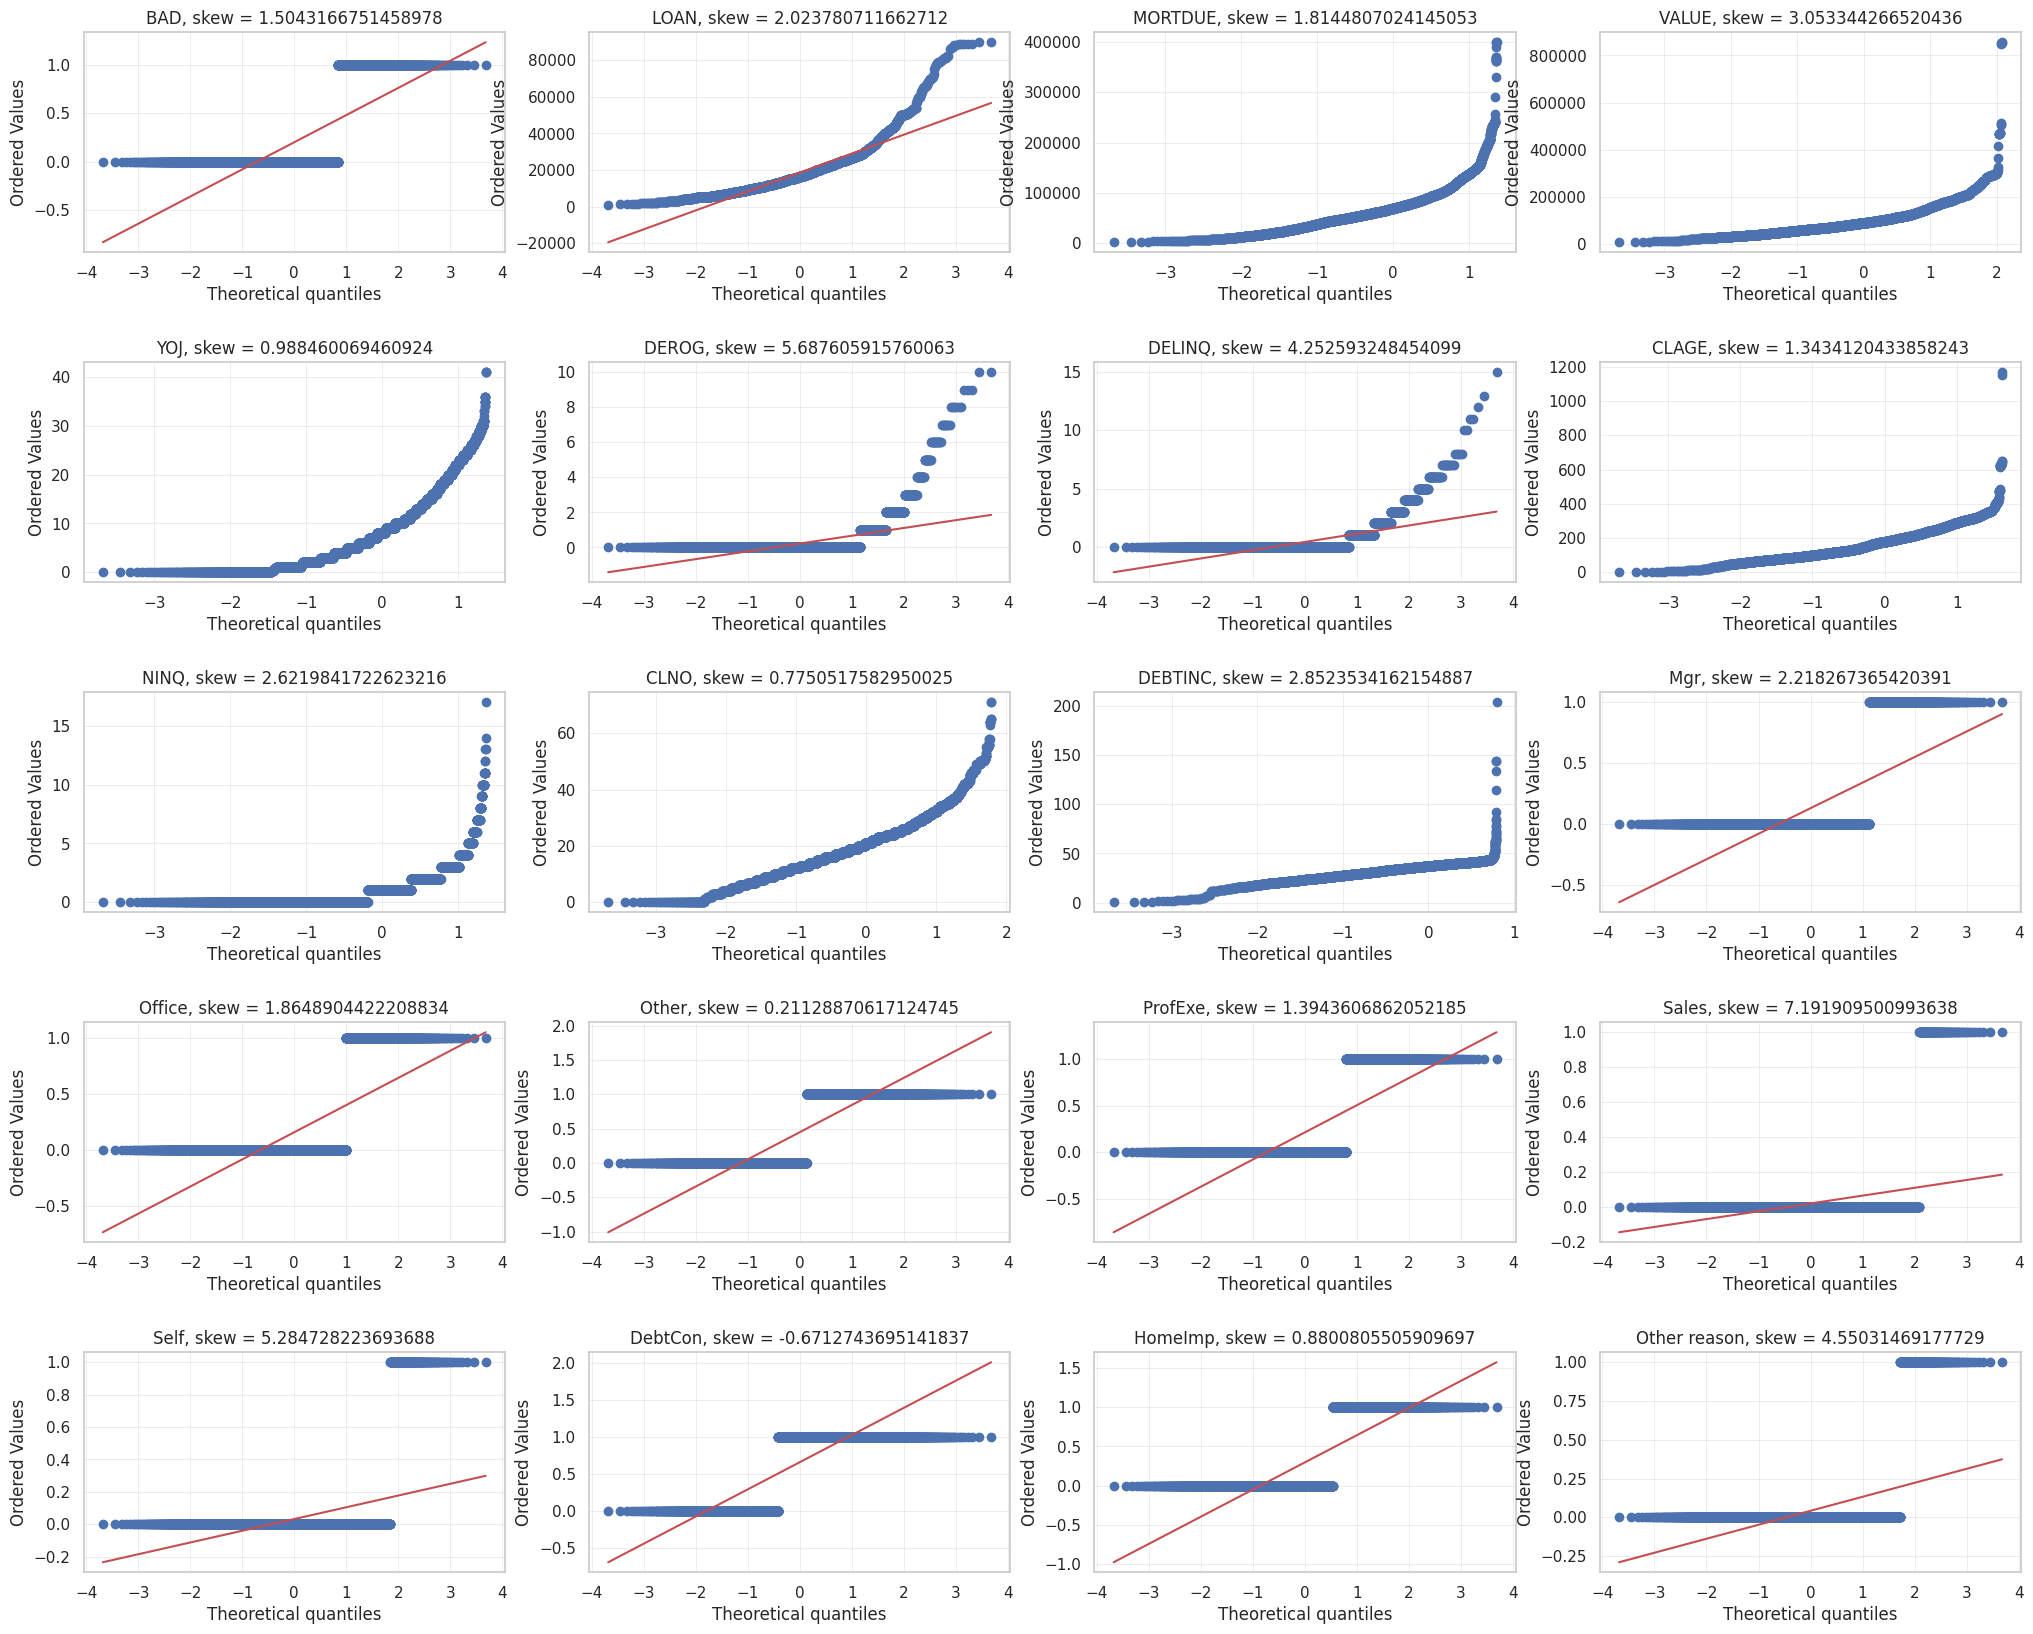

In [13]:
fig, axes = plt.subplots(5, 4, figsize=(25, 20))
for i,ax in zip(data.columns,axes.flat):
    probplot(data[i],dist='norm',plot=ax)
    title = i+f", skew = {data[i].skew()}"
    ax.set_title(title)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()


Now, while not entirely necessary, it would be preferrable for predictions to be made on our a version of our variables that is normally distributed. We can accomplish this via the following methods:

1. Taking our data, and raising it to the power of 1/8 (as performed within the notebook from [Akhil Shukla](https://www.kaggle.com/code/akhil14shukla/loan-defaulter-prediction/notebook), where the EDA performed is largely inspired from;)
2. Performing a yeo-johnson transformation, which is a function that helps mitigate skewedness in distributions that somewhat resemble a normal distribution.

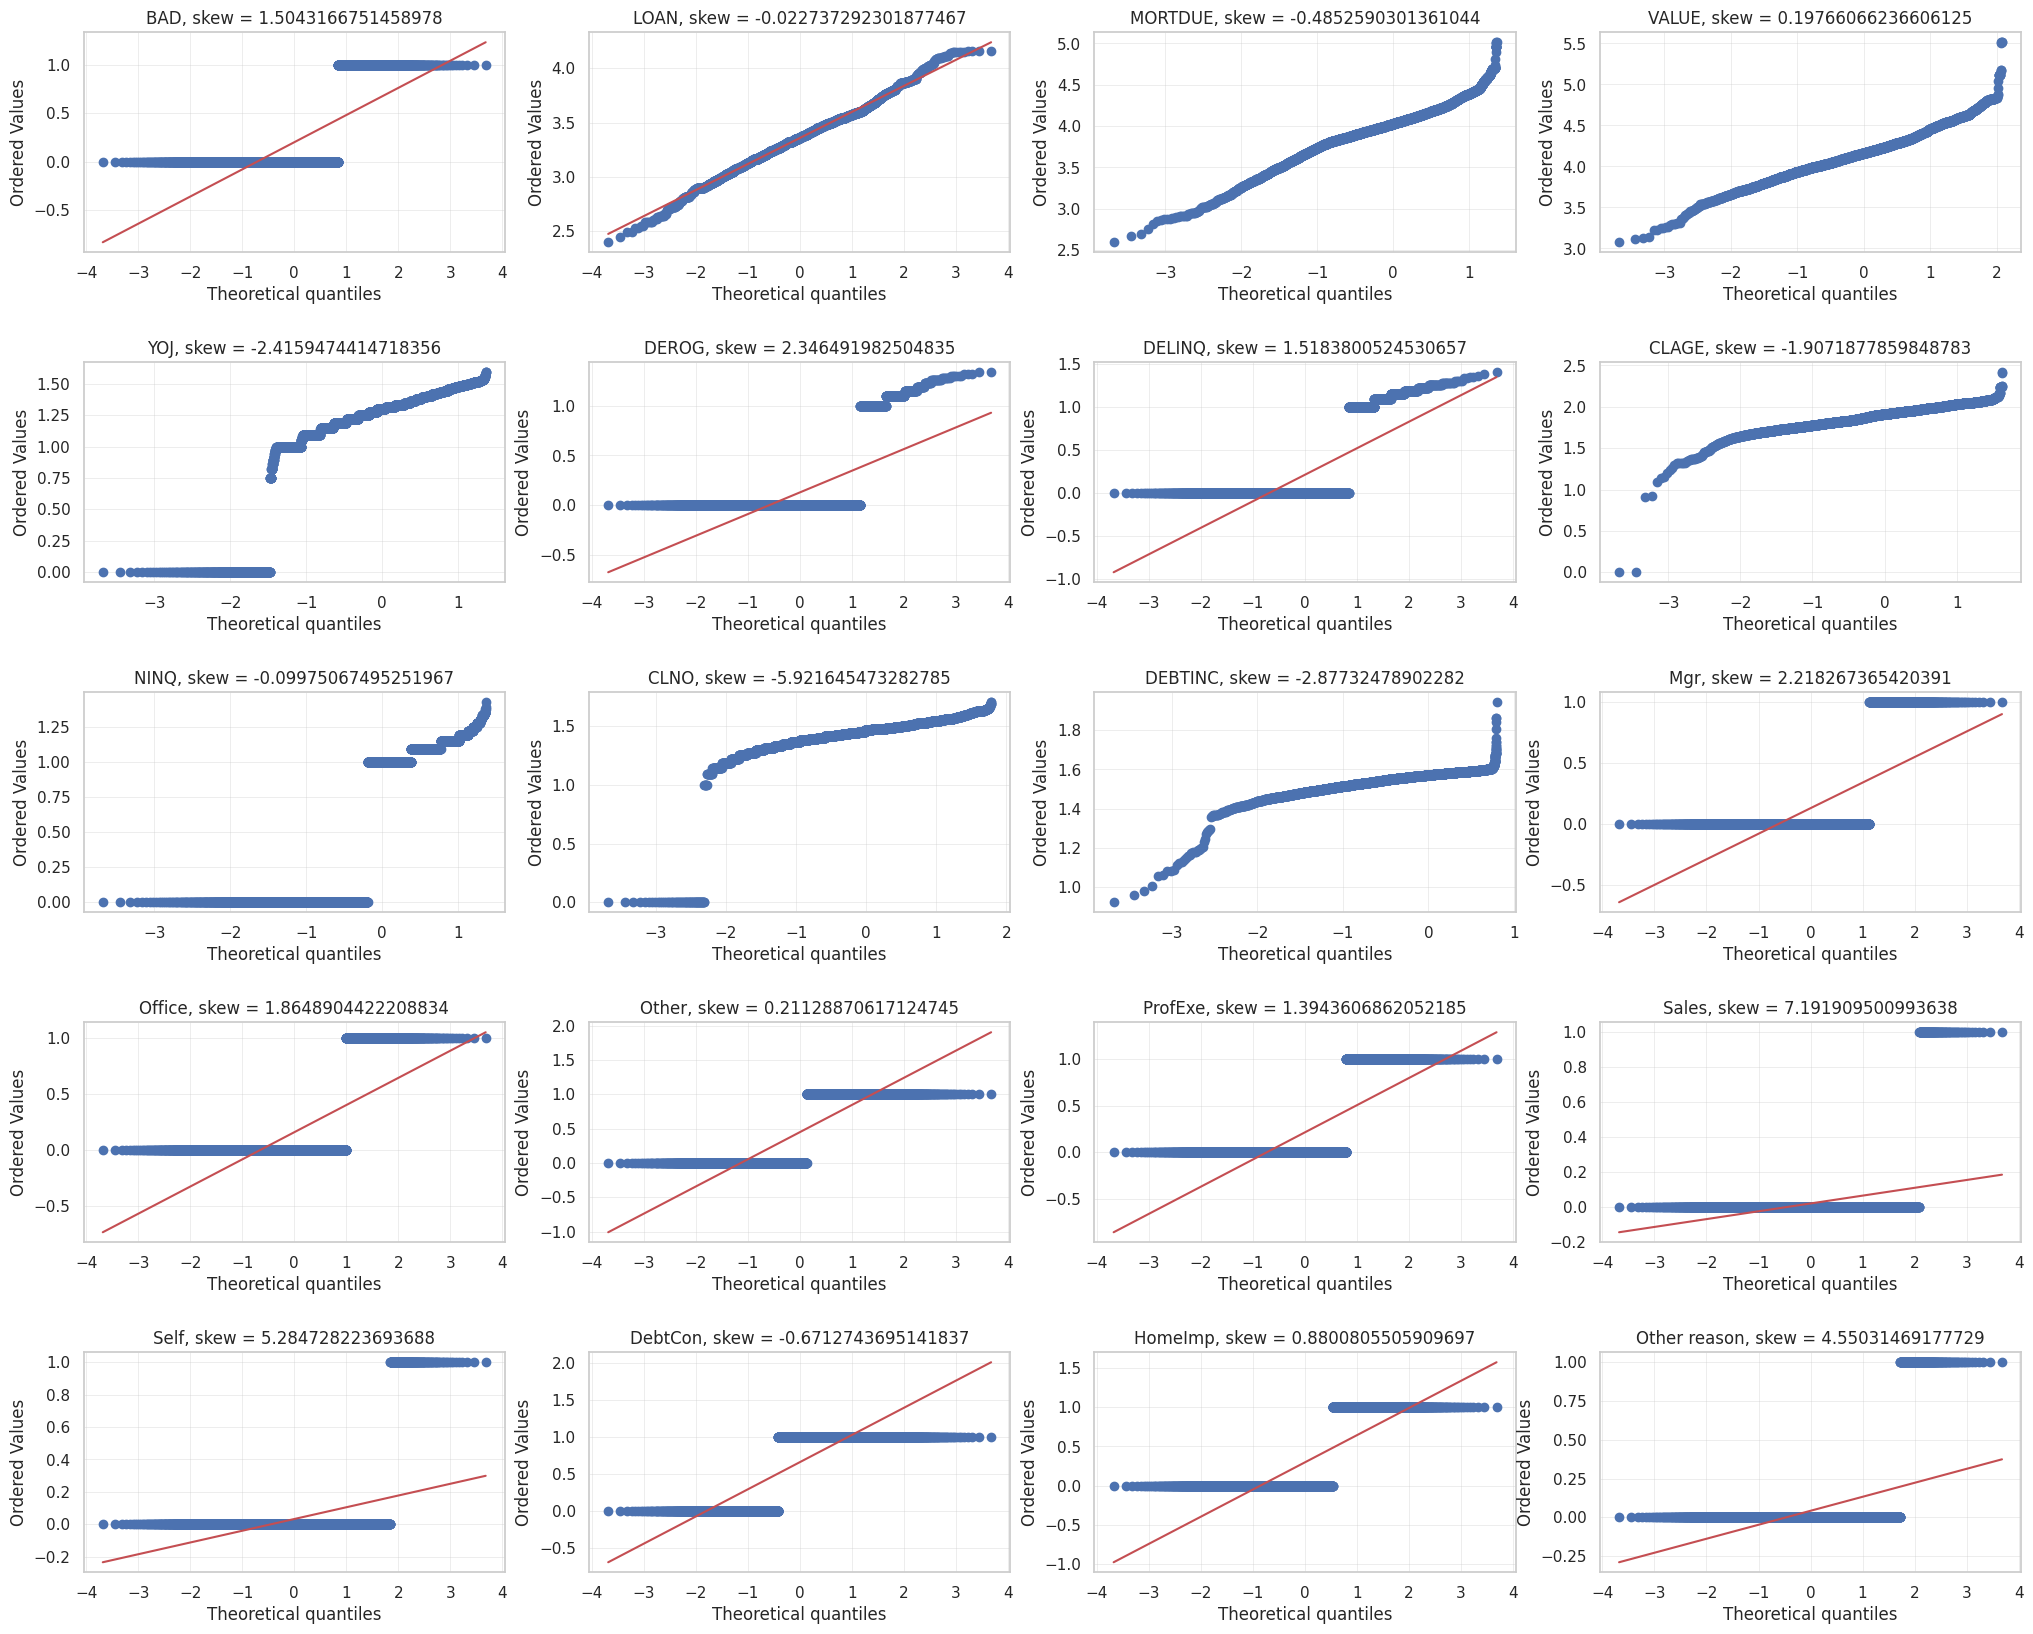

In [14]:
from scipy.stats import yeojohnson

# transforming data, plotting their values to the power of 1/8
fig, axes = plt.subplots(5, 4, figsize=(25, 20))
for i,ax in zip(data.columns,axes.flat):
    probplot(np.power(data[i],1/8),dist='norm',plot=ax)
    title = i+f", skew = {np.power(data[i],1/8).skew()}"
    ax.set_title(title)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Probability plot observations:
- Most of the features have different scalings, we need to normalize all the features that will be used for the model
- most of the variables have skewed distributions
- the variables `DEBTINC`, `LOAN`, `MORTDUE` and `VALUE` have outliers as indicated by the sudden change and dispersion in values as we approach the further quantiles.
  
To resolve these issues, we will perform the following (as done in the notebook:)

1. **Initial Relationship Visualisation** --- we will first assess the importance of features using a heat map of the respective correlation scores and another metric known as Predictive Power Score. The code for calculating this has been obtained from [this github repo](https://github.com/akhil14shukla/ppscore/blob/master/pps/ppscore.py), and is the same one used within the coded example (with some modifications due to differences in the version of python being used).

2. **Feature Engineering and basic feature selection** --- To rectify the skewdness and the lack of normally distributed predictors in our data, we will make transformations like raising the data in some of our variables to the power of 1/8 to make it appear more normally distributed, alongside other techniques like the yeo-johnson transformation and the log-transformation to mitigate skewness of our data. We will also be removing rows that do not have any apparent impact on the data (assessed from step 1, if their respective columns only contains 0s for their ppscore).

3. **Data normalization** --- We will use Z-score normalization, in addition to a min-max scaler prior, to normalize the data given that there are many variables (as previously mentioned) with outliers.
4. **Removing Missing data while preserving data volume** --- As evidenced from the heatmap of missing values plotted using the line of code `sns.heatmap(data.isnull(),cbar=False,yticklabels=False,cmap = 'viridis')`, it can be observed that we have many missing values for some rows. we will drop rows based on a threshold value since we need to balance improvements to data quality (from removing the rows with missing data) and the amount of data left. (This process is known as numerosity reduction)
5. **Revised Relationship Visualisation** ---We will plot these graphs again to ensure that our transformations are valid, and have made the data ideal for use with our proposed models. After this, we will perform feature selection and decide what set of features to use for which use cases.

# Ideally, these are the steps that should be taken for the first phase of our data pipeline, as it enters our Data Warehouse / Lakehouse.

### 1. Initial Relationship Visualisation
#### 1. Plotting correlation values

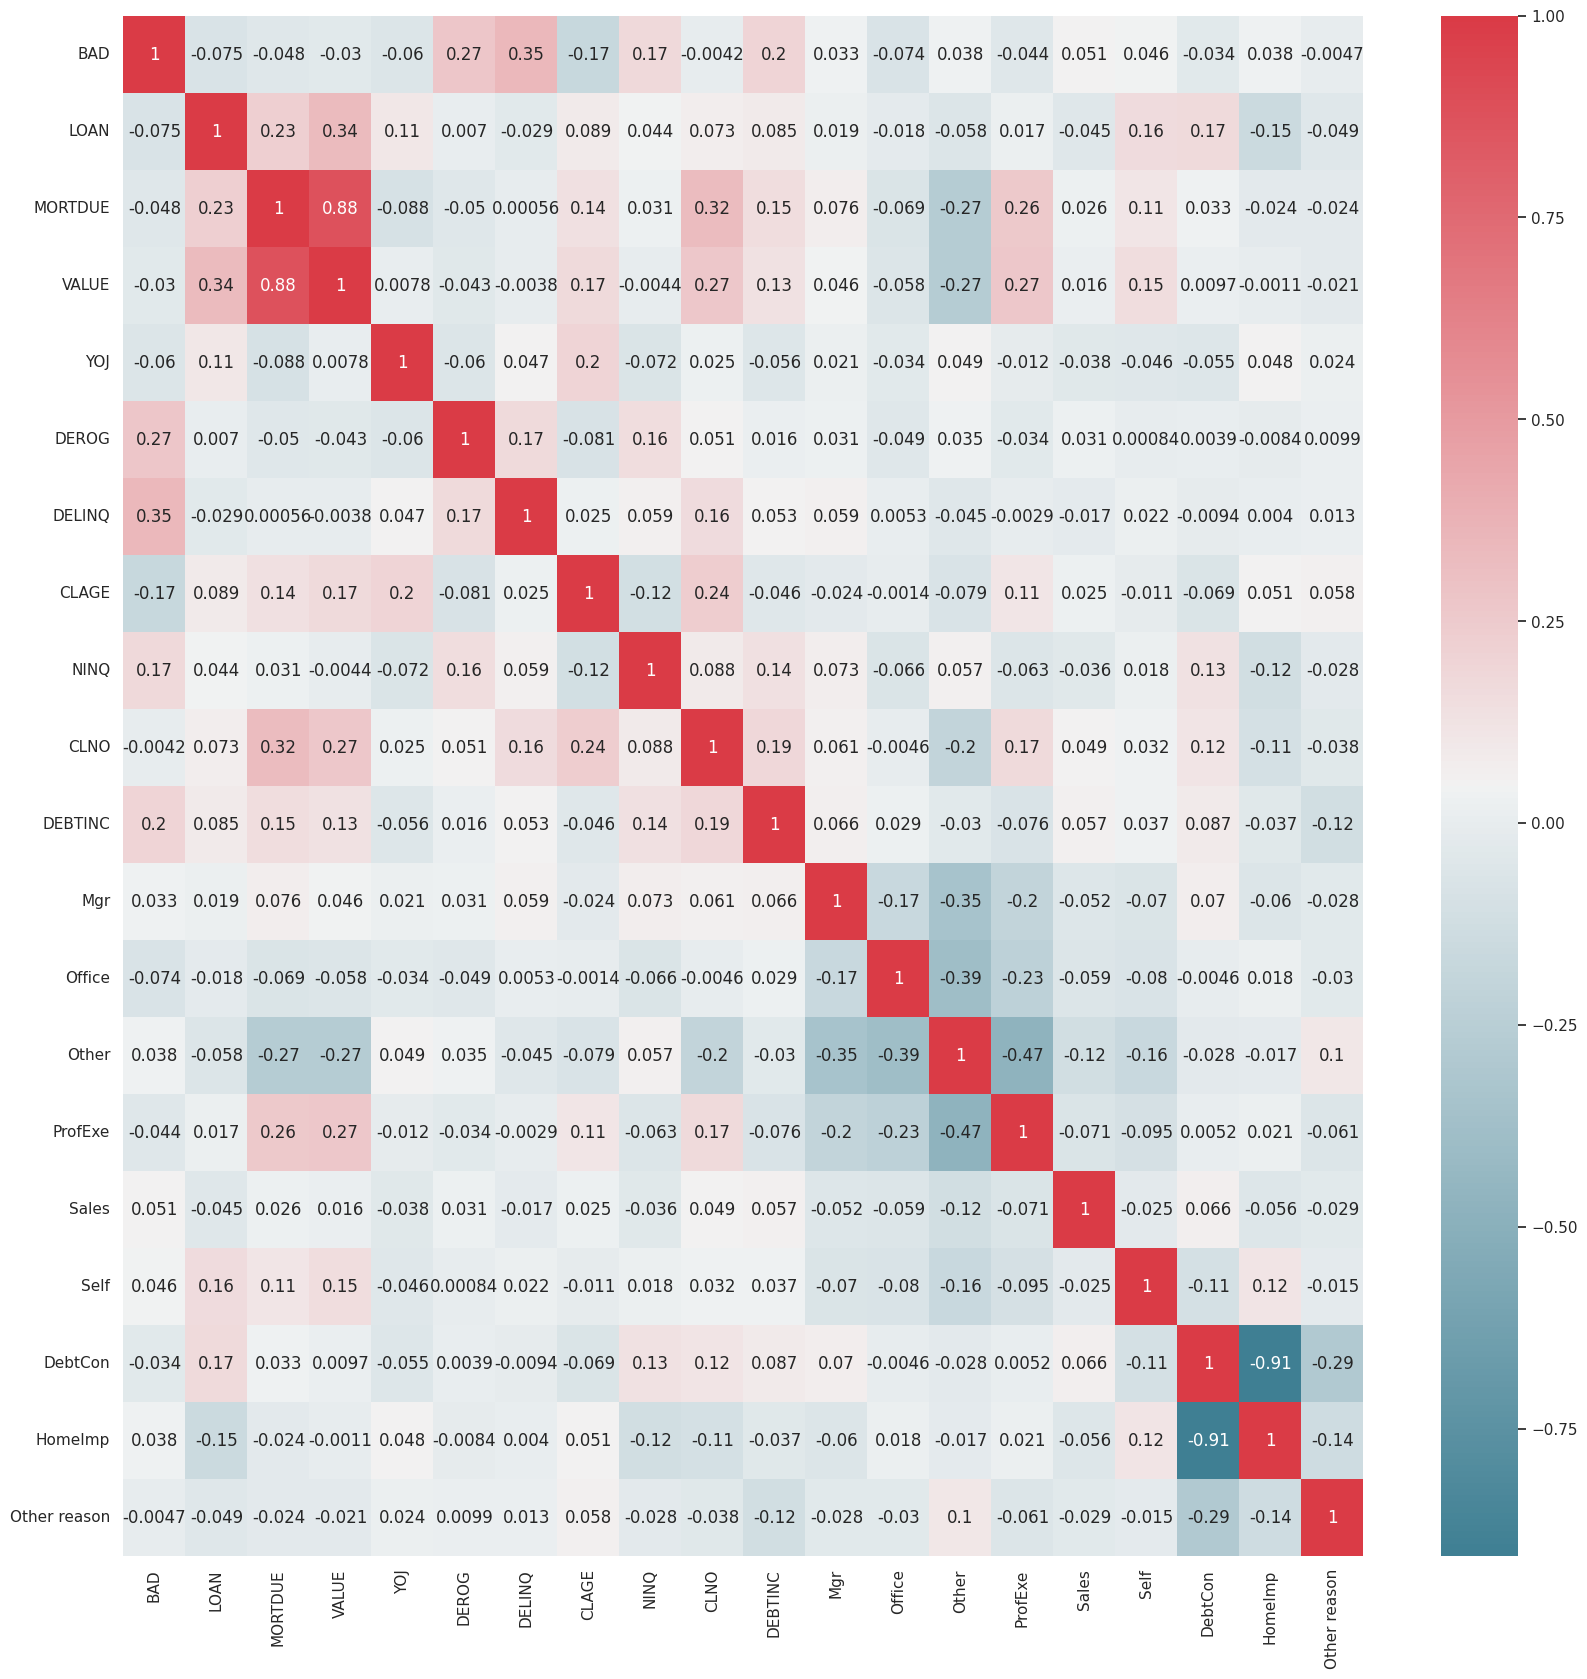

In [15]:
plt.figure(figsize=(20,20))
heat_map = sns.heatmap(data.corr(),cmap = colormap,annot=True)
heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=0)
plt.show()

Observations:  
- A strong positive correlation can be observed between variables `VALUE` and `MORTDUE` (0.88)
- A strong negative correlation can be observed between variables `HomeImp` and `DebtCon` (-0.91)
- there are weak correlations scattered across the predictors with values ranging from magnitudes of 0.47 to 0.03, indicating that there may be some combination that will help classify and provide a solid prediction.

#### 1. Plotting Predictive Power Score
We will first use a function to help create the predictive power scores for our dataset. The function, for a given dataframe, creates and trains a basic classifier for every unique pair of variables (either a decision tree regression model, or a decision tree classifier model if the dependent variable being predicted is a categorical one) and produce a predictive power score.  
  
  If the dependent variable is a categorical variable, the score is calculated as:
  $$\text{PPS} = \max\left(0, \frac{\text{F1 Score} - \text{Naive F1 Score}}{1 - \text{Naive F1 Score}}\right)$$

  If the dependent variable is a continuous variable, the score is calculated as:
  $$\text{PPS} = \max\left(0, 1 - \frac{\text{MAE}}{\text{Naive MAE}}\right)$$  
  
  However, note that these scores may have slight fluctuations with each iteration.


  

In [16]:
# using predefined pps score function written by Akhil Shukla

import pandas as pd
import numpy as np
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import metrics
from sklearn import preprocessing
from sklearn import utils
from sklearn.metrics import mean_absolute_error


def pps(df1,categorical_features=None,numerical_features=None):
    df=df1.fillna(value=df1.interpolate())
    df=df.fillna(value=df.mode())
    columns = ["Feature", "Target","PPS", "Type of Prediction", "Cross-Val Score", "Training Score","Naive-Baseline Score", "Model"]
    pps_df=pd.DataFrame(columns=columns)
    for i in df.columns:
        for j in df.columns:
            if(((categorical_features)!=None and j in categorical_features) or type(df[j])==str):
                model = DecisionTreeClassifier()
                lab_enc = preprocessing.LabelEncoder()
                label_encoded_y = np.array(lab_enc.fit_transform(df[j])).reshape(-1,1)
                x_train,x_test,y_train,y_test = train_test_split(np.array(df[i]).reshape(-1,1),label_encoded_y)
                model.fit(x_train,y_train)
                y_pred=model.predict(x_test)
                mode = np.full((len(x_test),1),df[j].mode())
                f1 = 0
                f1_naive=0
                if(df[j].unique().shape[0]>2):
                    f1 = metrics.f1_score(y_test,y_pred,average='weighted')
                    f1_naive = metrics.f1_score(y_test,mode,average='weighted')
                else:
                    f1=metrics.f1_score(y_test,y_pred)
                    f1_naive = metrics.f1_score(y_test,mode)
                pps_score=max(0,(f1-f1_naive)/(1 - f1_naive))
                cv_score=model.score(x_test,y_test)
                train_score=model.score(x_train,y_train)
                new_row = {"Feature":i,"Target":j,"PPS":pps_score,"Type of Prediction":"Classification","Cross-Val Score":cv_score,"Training Score":train_score,"Naive-Baseline Score":f1_naive,"Model":"DecisionTreeClassifier()"}
                if not pps_df.empty:
                  pps_df = pd.concat([pps_df, pd.DataFrame([new_row])], ignore_index=True)
                else:
                  pps_df = pd.DataFrame([new_row])
            else:
                model = DecisionTreeRegressor()
                lab_enc = preprocessing.LabelEncoder()
                label_encoded_y = np.array(lab_enc.fit_transform(df[j])).reshape(-1,1)
                x_train,x_test,y_train,y_test = train_test_split(np.array(df[i]).reshape(-1,1),np.array(df[j]).reshape(-1,1))
                model.fit(x_train,y_train)
                median = np.full((len(x_test),1),df[j].median())
                naive_mae = metrics.mean_absolute_error(y_test, median)
                y_pred=model.predict(x_test)
                mae=metrics.mean_absolute_error(y_test,y_pred)
                train_score=mean_absolute_error(y_train,model.predict(x_train))
                pps_score = max(0,1 - mae/naive_mae)
                new_row = {"Feature":i,"Target":j,"PPS":pps_score,"Type of Prediction":"Regression","Cross-Val Score":mae,"Training Score":train_score,"Naive-Baseline Score":naive_mae,"Model":"DecisionTreeRegressor()"}
                if not pps_df.empty:
                  pps_df = pd.concat([pps_df, pd.DataFrame([new_row])], ignore_index=True)
                else:
                  pps_df = pd.DataFrame([new_row])
    return pps_df

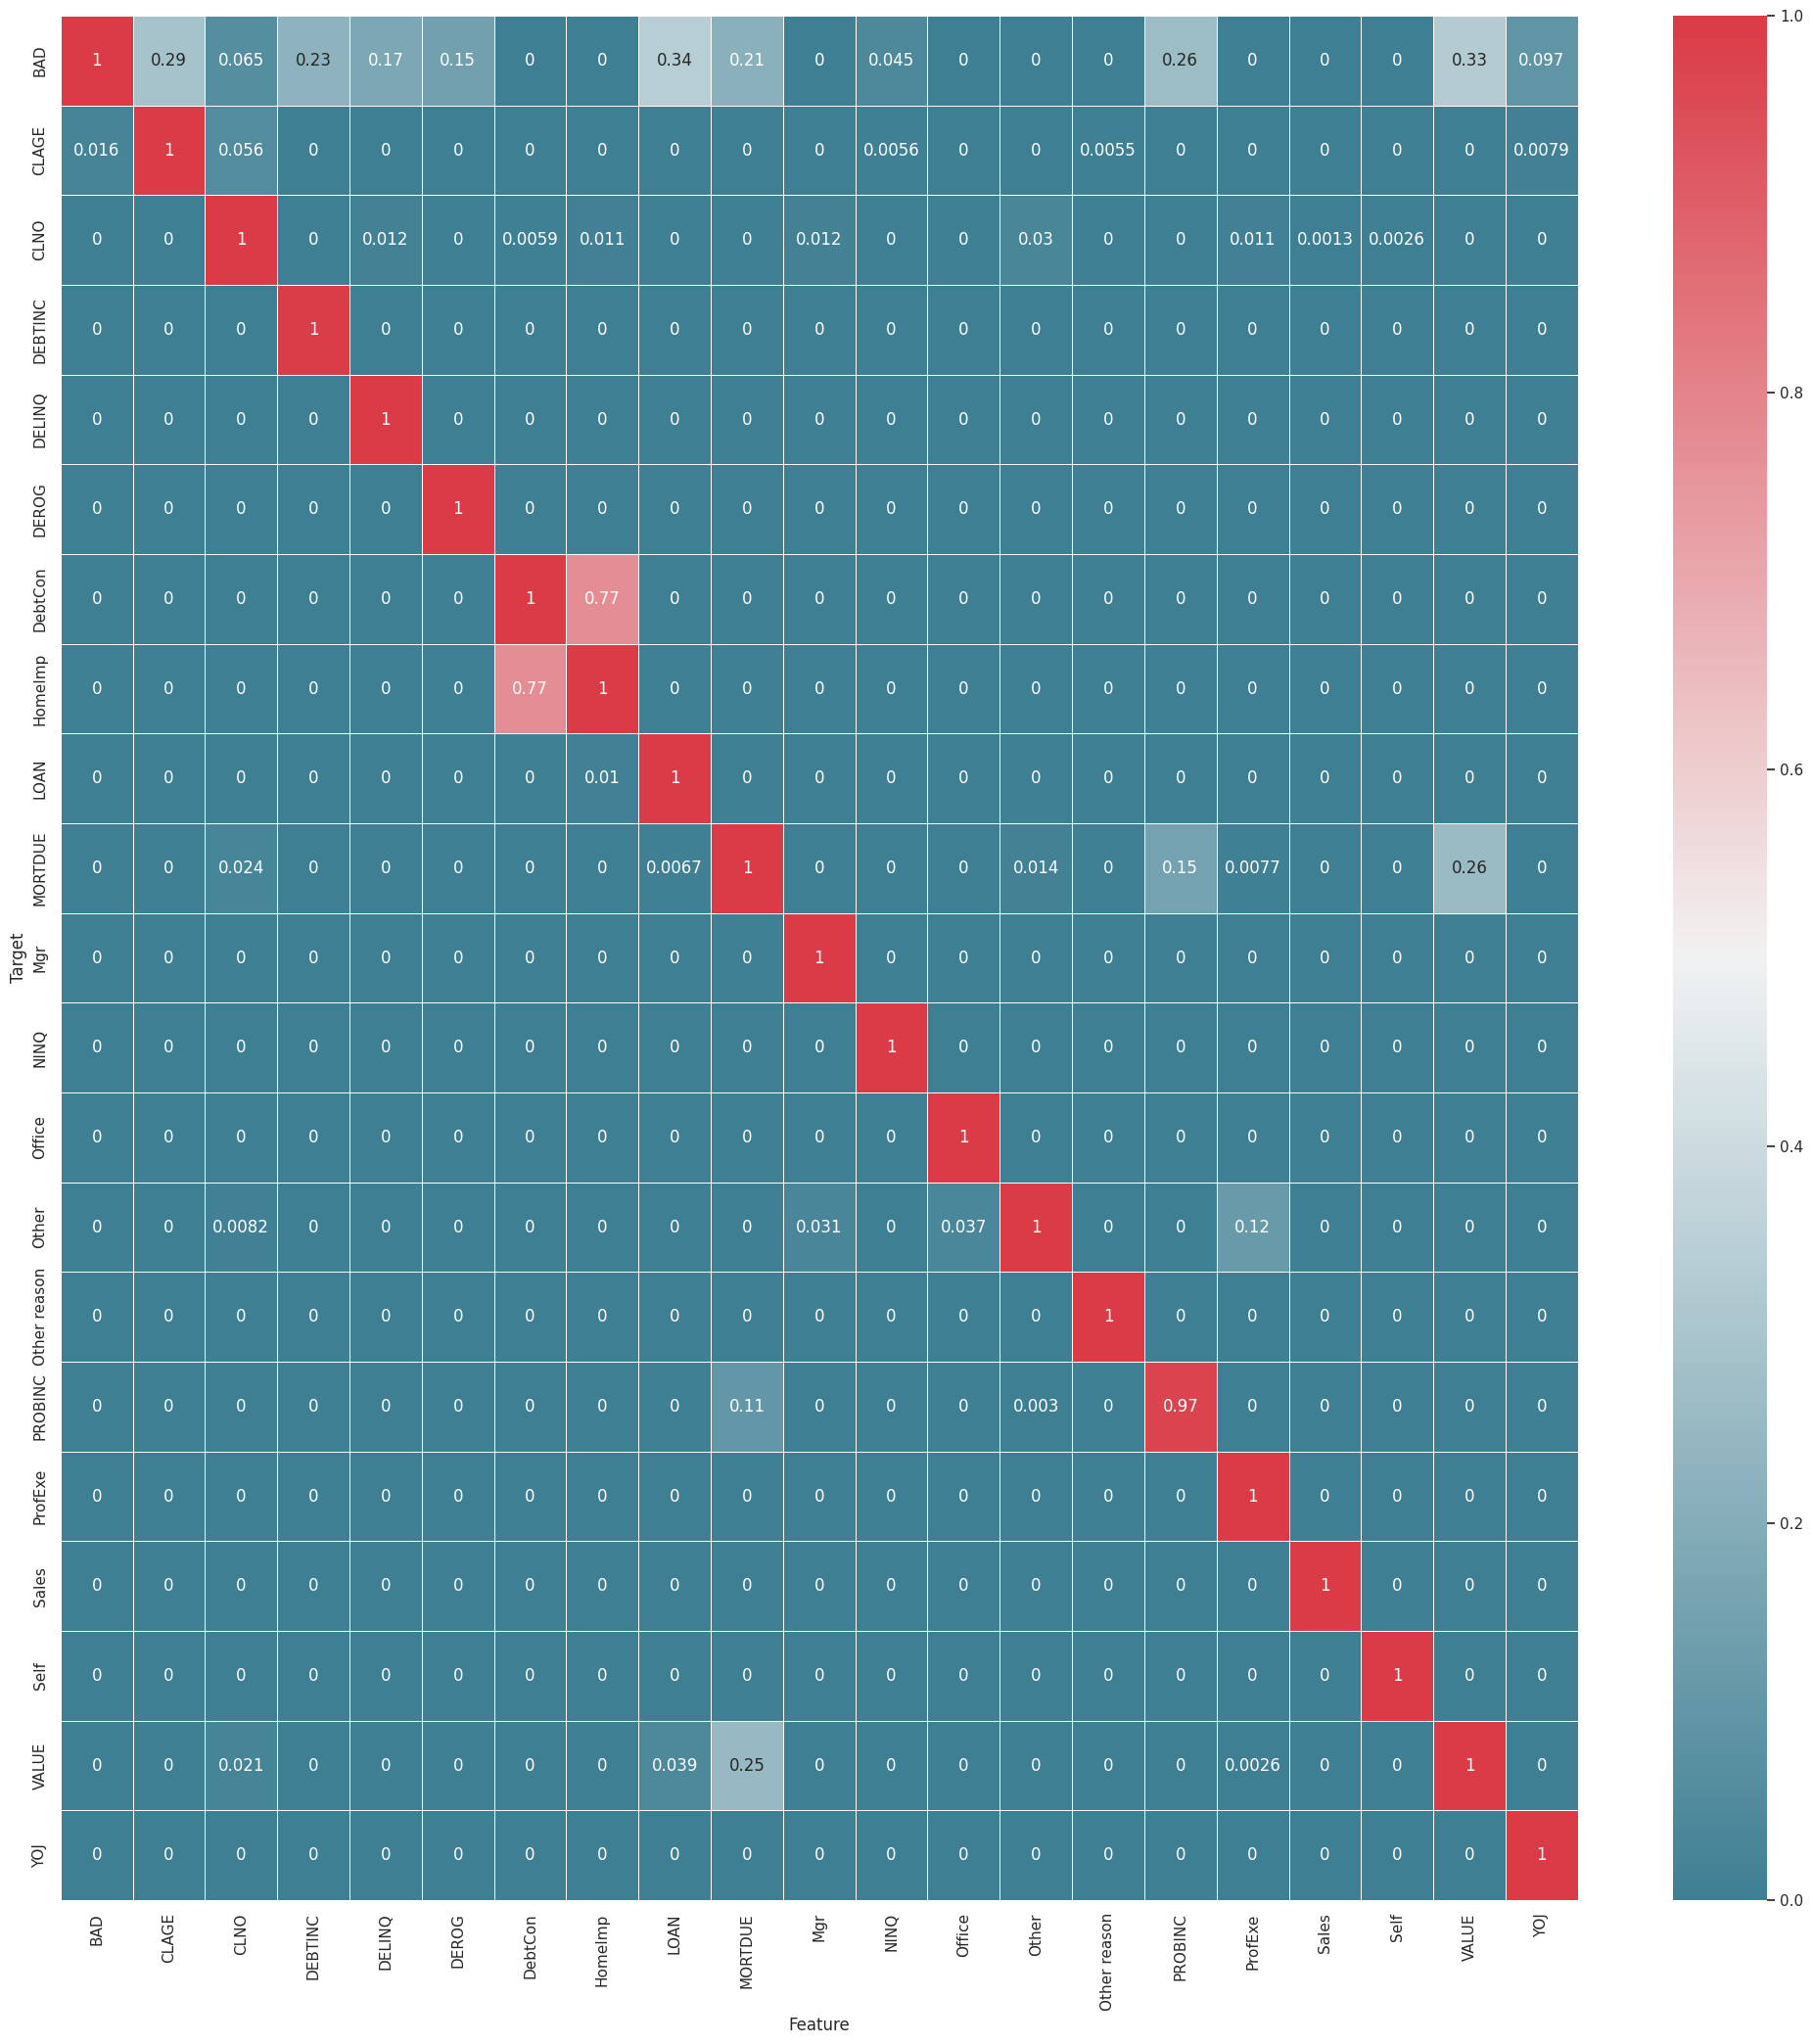

In [48]:
plt.figure(figsize=(25,25))
matrix_df = pps(data,["BAD","JOB","REASON"])[['Feature', 'Target', 'PPS']].pivot(columns='Feature', index='Target', values='PPS')
sns.heatmap(matrix_df, vmin=0, vmax=1, cmap=colormap, linewidths=0.5,annot=True)
plt.show()

### 2. Feature engineering and feature selection


We will first add a new derived variable that is relevant for our calculations: `PROBINC`:  
The ratio of an applicant's current debt on mortgage (`MORTDUE`) and their debt-to-income ratio (`DEBTINC`).

In [18]:
data["PROBINC"] = data.MORTDUE/data.DEBTINC
basic_rectified_data = data.copy()
basic_rectified_data.to_csv('./basic_rectified_data.csv') # remmember to download if notebook is run on colab, kaggle or otherwise cloud-hosted

Next, we transform the data:

To reiterate, we will be making the following transformations:
1. to values that do not seem to follow a normal distribution, we will raise it to the power of 1/8
2. to relatively skewed data, we will apply the [yeo-johnson transformation](https://feaz-book.com/numeric-yeojohnson), which is a function that helps mitigate skewedness in distributions that somewhat resemble a normal distribution.
3. to data with awkward skewed proportions due to scale, we will apply a log-transformation which will mitigate this.

In [19]:
LOAN_ONLY = data.copy()
LOAN_ONLY["LOAN"] = yeojohnson(LOAN_ONLY["LOAN"])[0]  # transforming LOAN using yeo-johnson method
LOAN_PP = LOAN_ONLY.copy()
LOAN_ONLY.to_csv('./LOAN_ONLY.csv')

LOAN_PP["MORTDUE"] = np.power(LOAN_PP["MORTDUE"],1/8)     # transforming MORTDUE by raising it to 1/8

#log-transforming other variables
LOAN_PP["YOJ"] = np.log(LOAN_PP["YOJ"]+10)
LOAN_PP["VALUE"] = np.log(LOAN_PP["VALUE"]+10)
LOAN_PP["CLNO"] = np.log(LOAN_PP["CLNO"]+10)

LOAN_PP.to_csv('./LOAN_PP.csv')

Lastly, we will remove the variables that do not have any apparent effect on any other variables, assessed by on whether their associated row and column has any non-zero ppscores in the ppscore heatmap.

In [20]:
all_variables = list(set(data.columns)-{'PROBINC'}) # getting all rows except PROBINC because we didnt plot it in

#get all variables with non-zero ppscore
pps_scored = []
for i in matrix_df.columns:
  for j in matrix_df.columns:
    pps_scored.extend((i,j)) if matrix_df.loc[i,j] != 0 and i!= j else None

unimportant_features= list( set(all_variables) - set(pps_scored))
print("Unimportant features:",unimportant_features)

Unimportant features: ['Sales', 'Mgr', 'Self']


As seen from above, the columns that do not have any significant impact on the others are the encoded variables `Other reason`, `Sales`, `Self`, thus we will not be including them. Furthermore, `HomeImp` seems to have too high a ppscore and correlation with `MORTDUE`, and we do not need features that are too correlated to others (since one can approximate to the other, it isn't really necessary), hence we would remove `HomeImp` as well.

In [45]:
DATA_PRUNED = LOAN_PP.copy()
DATA_PRUNED.drop(['MORTDUE',"HomeImp", "Other reason","Sales", "Self"],axis=1,inplace=True)
DATA_PRUNED.to_csv('./DATA_PRUNED.csv')

Thus, we have 4 versions of our data:  

| Dataframe    | Desc |
| -------- | ------- |
| basic_rectified_data  | data has been sparingly cleaned, resembles raw data except for some imputation|
| LOAN_ONLY | transformed LOAN only |
| LOAN_PP    | transformed LOAN and some other variables    |
| DATA_PRUNED    | transformed LOAN and some other variables, feature selection performed |


### 3. Data Normalization

For this implementation, we will follow the methods prescribed in the example notebook and reuse the functions for applying standardization and min-max normalization to the data.

In [22]:
def preprocess(df):
  df1 = df.copy()
  # Numerosity Reduction, with a threshold of 4 null values
  df1.dropna(axis=0,thresh=4,inplace=True)
  # Filling the rest of the null values using interpolated values, mode and median
  df1.fillna(value=df1.interpolate(),inplace=True)
  df1.fillna(value=df1.mode(),inplace=True)
  df1.fillna(value=0,inplace=True)
  # Taking out the target column before using #standard scaler
  y = df["BAD"]
  df1.drop(["BAD"],axis=1,inplace=True)

  # Using Standard Scaler, as it might also take care of some outliers
  sscaler = StandardScaler()
  scaled_features = sscaler.fit_transform(df1)

  # Standard Scaler retuen a numpy array, convertig it back into a DataFrame, for ease of understanding
  scaled_features_df = pd.DataFrame(scaled_features, index=df1.index, columns=df1.columns)
  return scaled_features_df,y

def preprocess_min_max(df):
  df1 = df.copy()
  # Numerosity Reduction, with a threshold of 4 null values
  df1.dropna(axis=0,thresh=4,inplace=True)
  # Filling the rest of the null values using interpolated values, mode and median
  df1.fillna(value=df1.interpolate(),inplace=True)
  df1.fillna(value=df1.mode(),inplace=True)
  df1.fillna(value=0,inplace=True)
  # Taking out the target column before using #standard scaler
  y = df["BAD"]
  df1.drop(["BAD"],axis=1,inplace=True)

  # Using Standard Scaler, as it might also take care of some outliers
  sscaler = MinMaxScaler()
  scaled_features = sscaler.fit_transform(df1)

  # Standard Scaler retuen a numpy array, convertig it back into a DataFrame, for ease of understanding
  scaled_features_df = pd.DataFrame(scaled_features, index=df1.index, columns=df1.columns)
  return scaled_features_df,y

We will only perform min-max normalization first, due to how some models do not explicitly require a standardized plot, thus it would be preferrable if the information was not modified at this stage. Thus, we will refrain from transforming our data until we begin training our model.  
  
  We also perform a chi-squared test to assess whether a strong relationship does exist with most of our predictor variables (albeit it is traditionally used for categorical data, it still gives a good sense of what will likely be the strongest predictors.)

<Axes: >

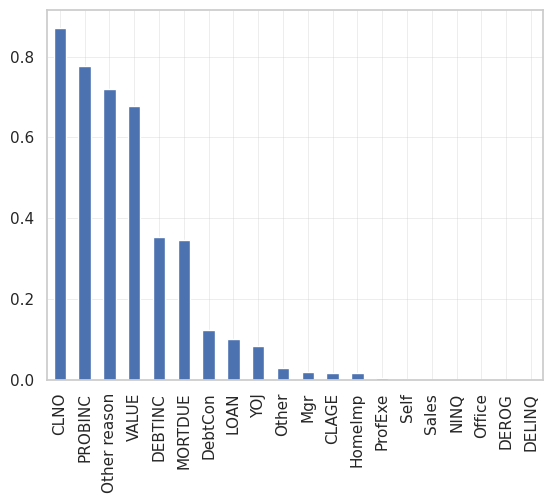

In [23]:
# run preprocessing function for minmaxing data
x1,y1 = preprocess_min_max(data)

chi_scores = chi2(x1,y1)
p_values = pd.Series(chi_scores[1],index = x1.columns)
p_values.sort_values(ascending = False , inplace = True)
p_values.plot.bar()

### 4. Removing Missing data while preserving data volume

As per outlier removal convention, we will remove outliers that are are greater than the third quartile, or smaller than the first quartile, by a magnitude of 1.5 times the interquartile range.

In [41]:
def remove_outlier_IQR(df):
    # Select only numerical columns for outlier detection
    num_cols = df.select_dtypes(include=np.number).columns
    # print(num_cols)
    # num_cols = list(num_cols) + ['Mgr','Office','ProfExe','Sales','Self','Other reason']

    # Calculate quartiles and IQR only for numerical columns
    Q1 = df[num_cols].quantile(0.25)
    Q3 = df[num_cols].quantile(0.75)
    IQR = Q3 - Q1

    # Create outlier mask only for numerical columns
    mask = ~(
        (df[num_cols] < (Q1 - 1.5 * IQR)) |
        (df[num_cols] > (Q3 + 1.5 * IQR))
    ).any(axis=1)

    return df[mask]

# cols = ['LOAN','MORTDUE','VALUE','DEBTINC']
test = data.copy()
test = remove_outlier_IQR(test)
print("Number of outliers removed : " , str((data.shape[0]-test.shape[0])/data.shape[0] * 100)+"%")

Number of outliers removed :  46.946308724832214%


However, as almost half of the data was repmoved, the data quality has decreased, thus we will instead only remove rows during normalization (with the functions `preprocess` and `preprocess_min_max`) that have more than 4 missing values.

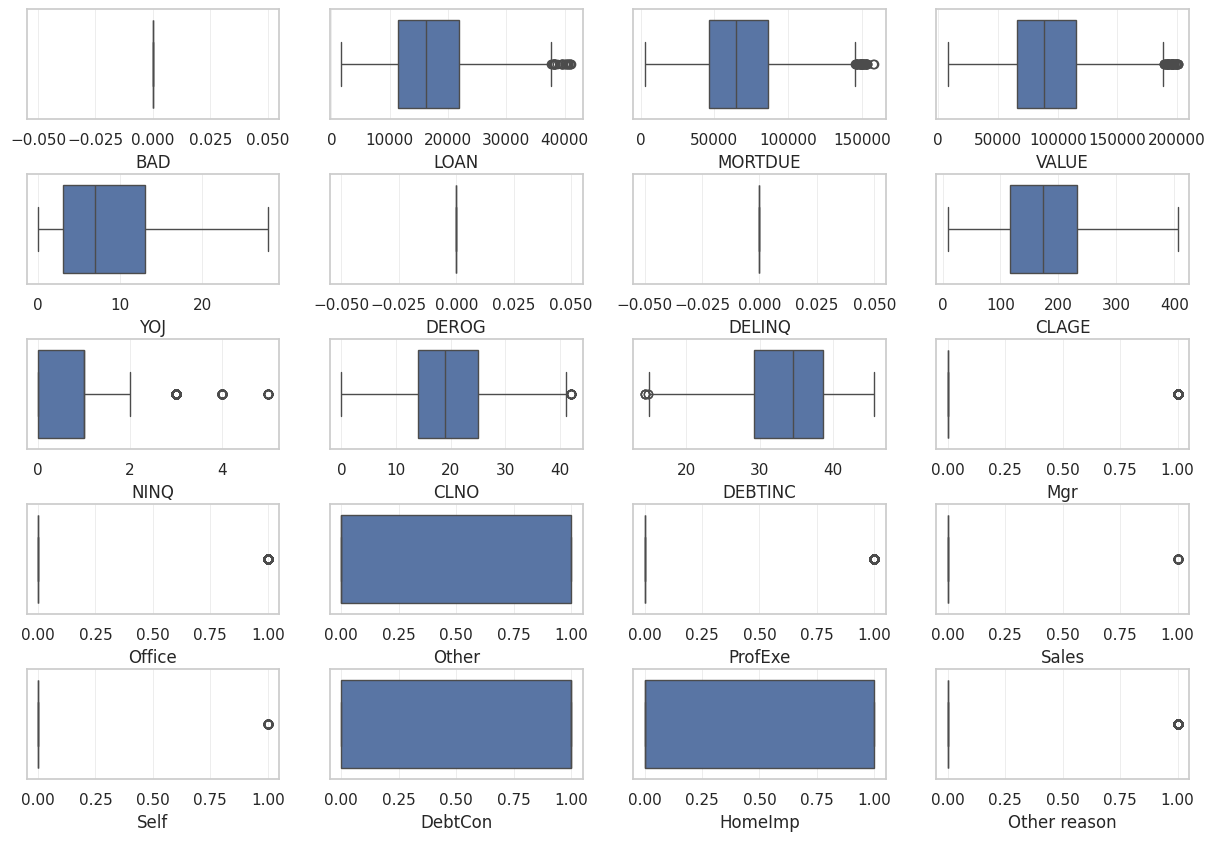

In [30]:
fig, axes = plt.subplots(5, 4, figsize=(15, 10),)
for i,ax in zip(test.columns,axes.flat):
    sns.boxplot(x = test[i],ax=ax)     # we can also use violin plot
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

### 5. Re-plotting data and assessing new inter-variable relationships

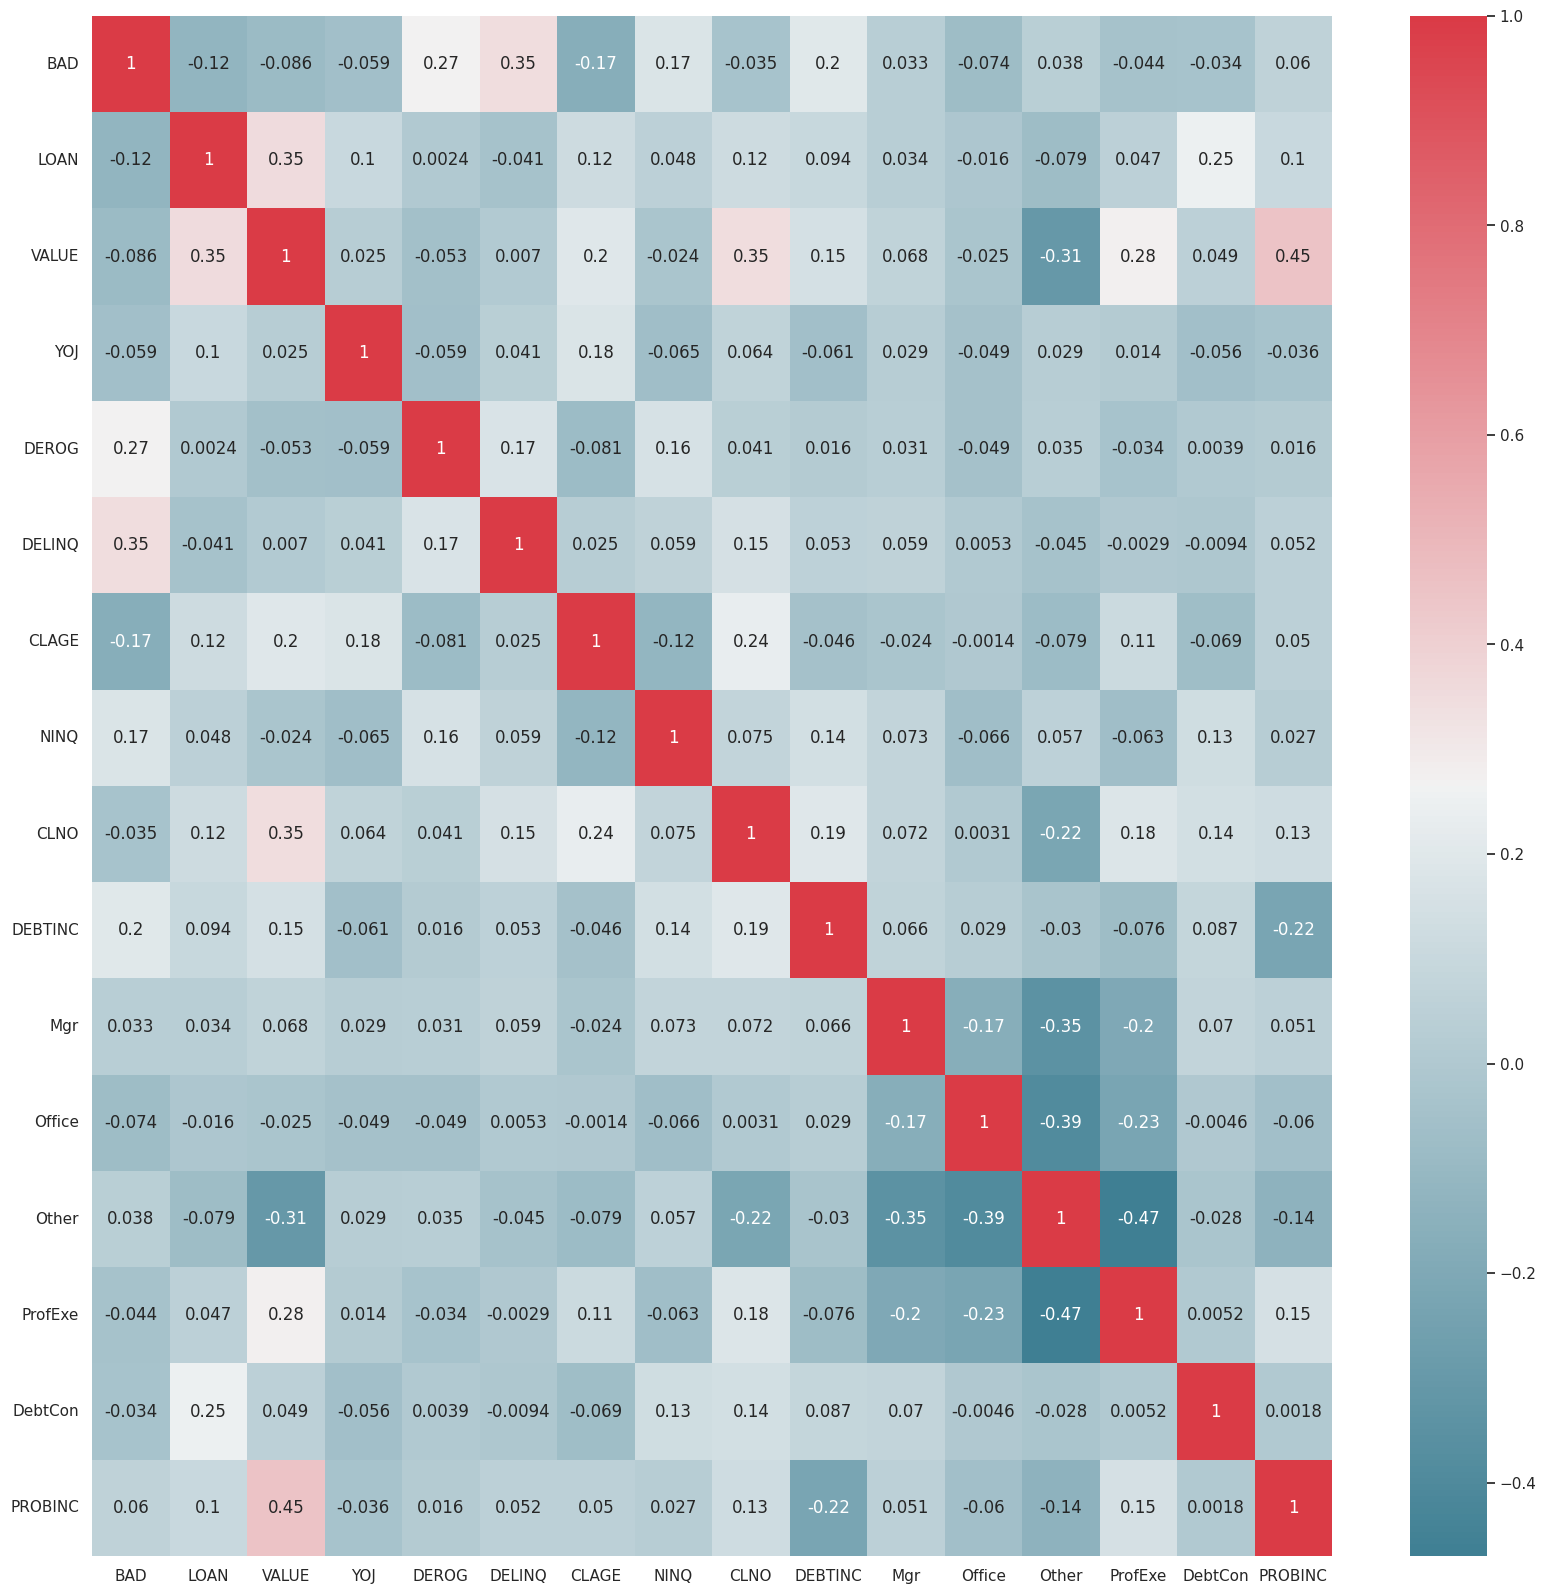

In [47]:
plt.figure(figsize=(20,20))
heat_map = sns.heatmap(DATA_PRUNED.corr(),cmap = colormap,annot=True)
heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=0)
plt.show()

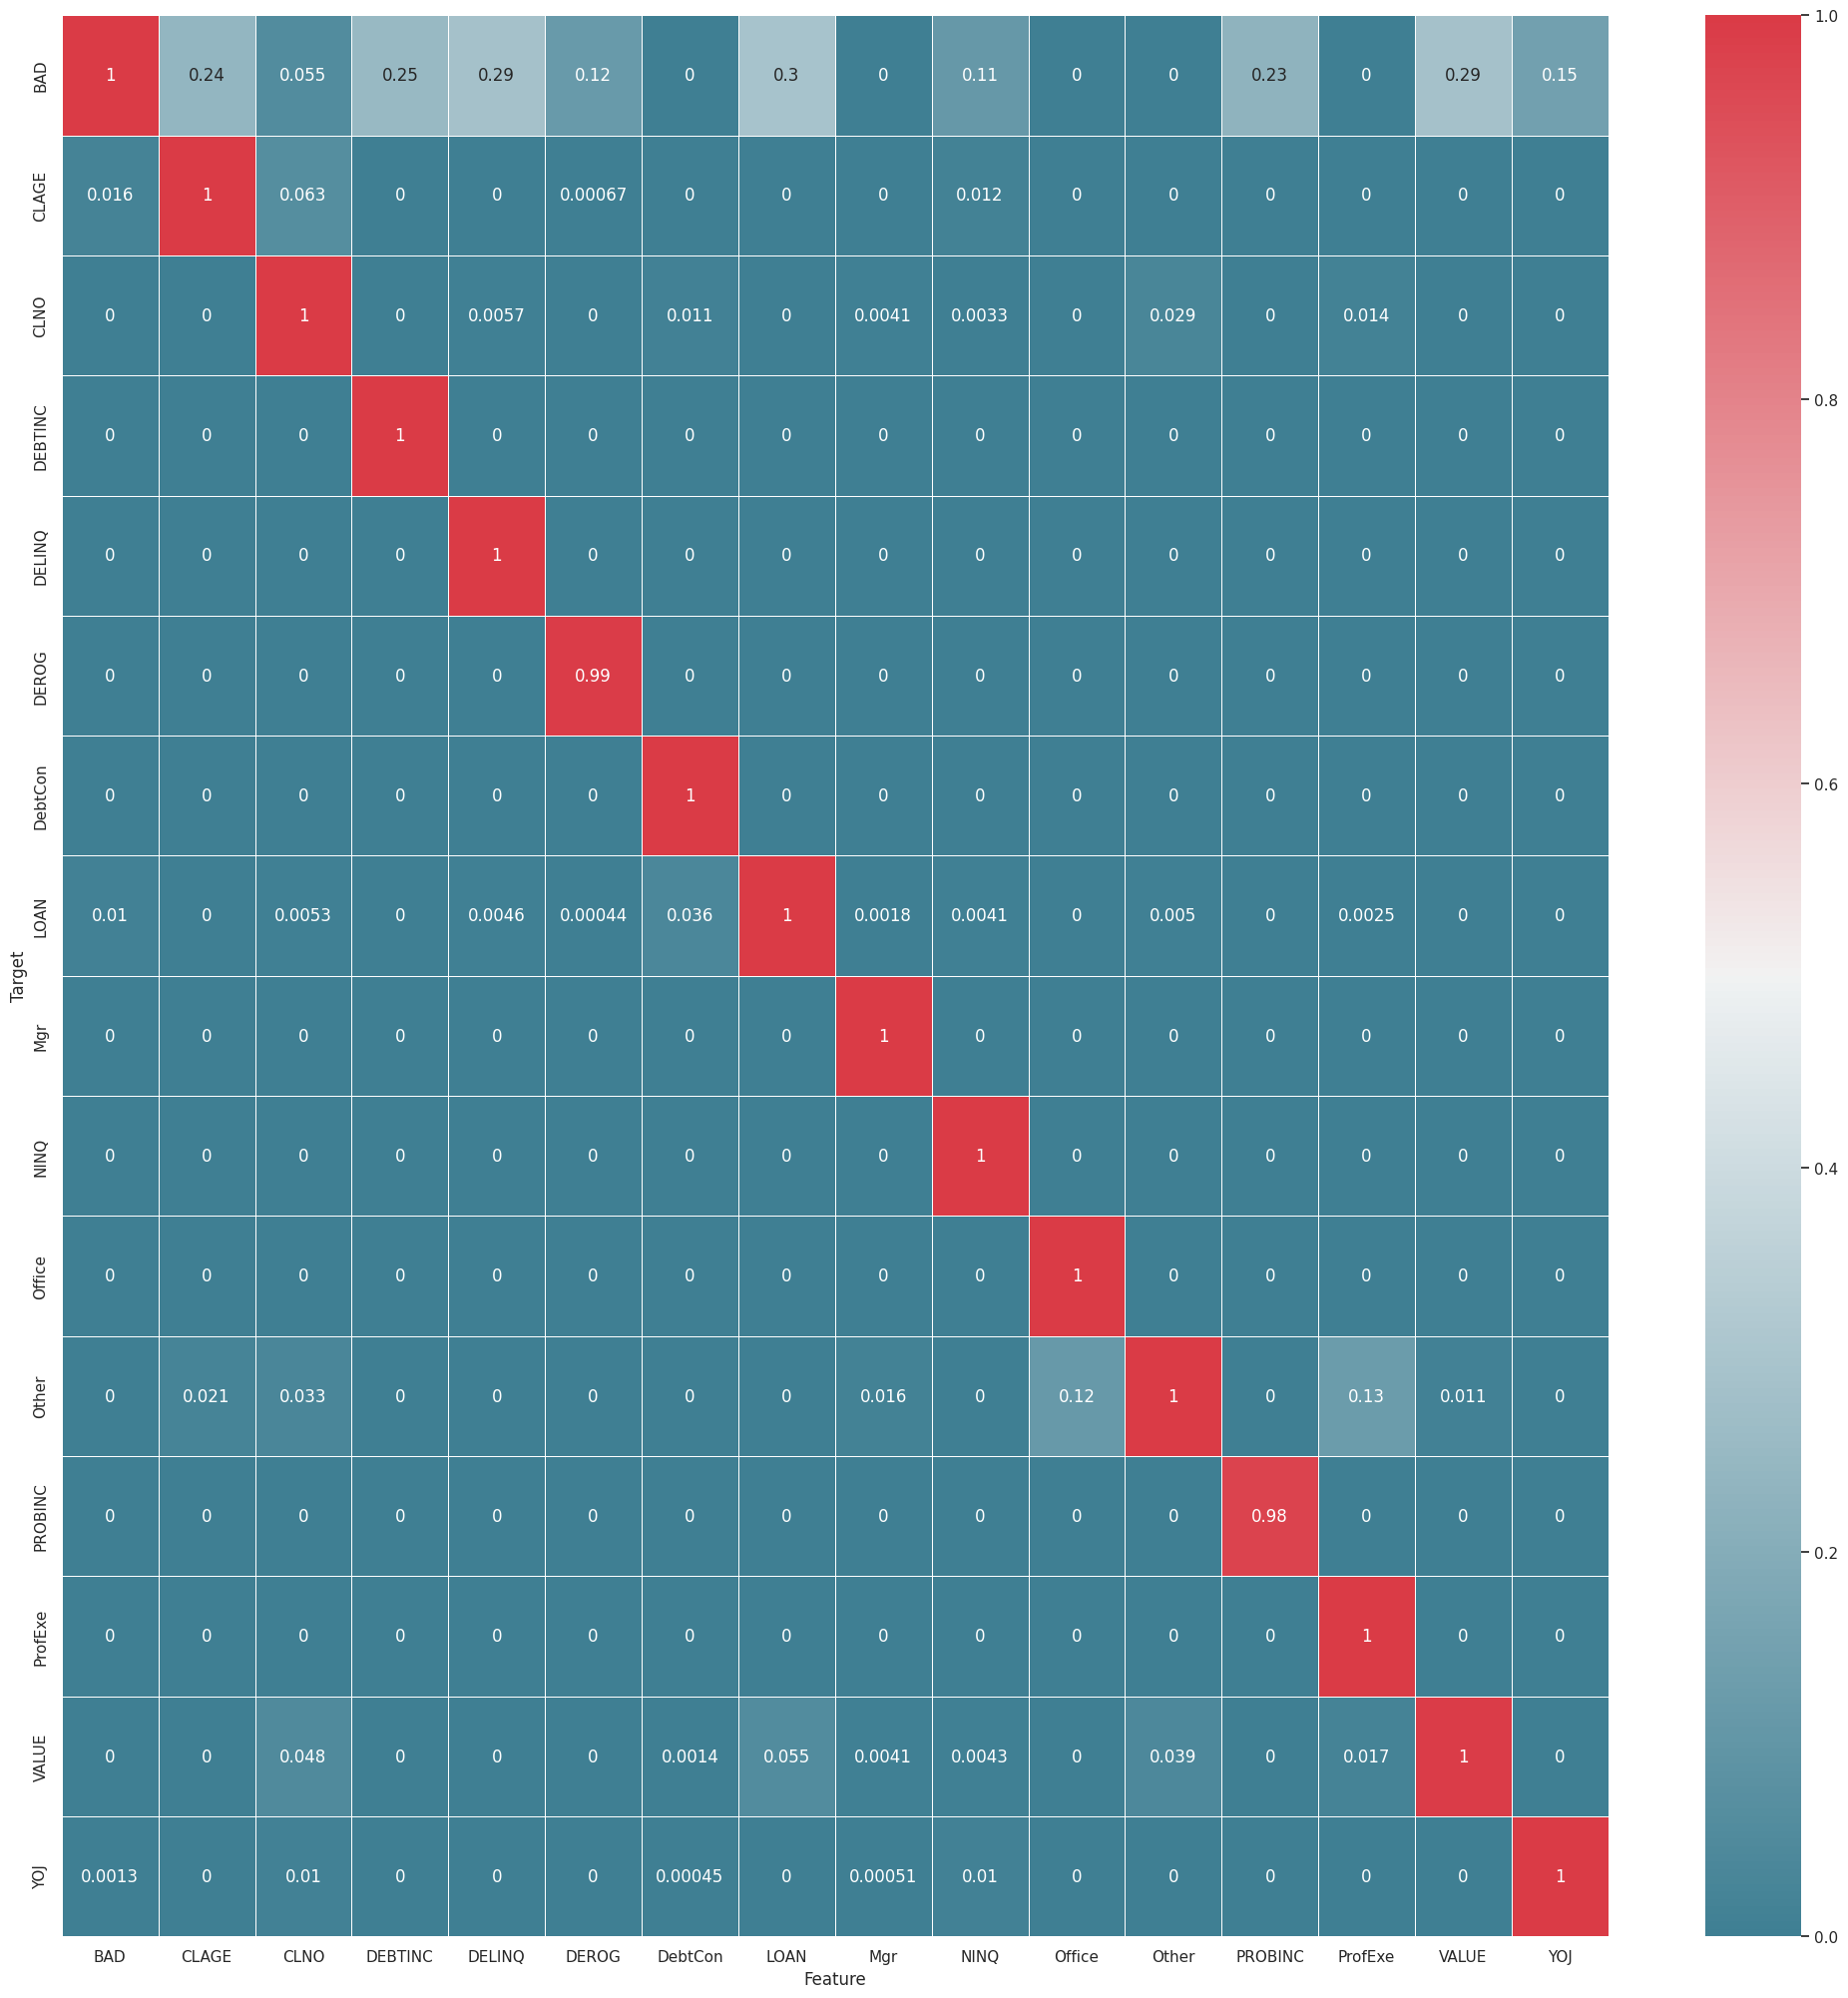

In [50]:
plt.figure(figsize=(25,25))
matrix_df = pps(DATA_PRUNED,["BAD","JOB","REASON"])[['Feature', 'Target', 'PPS']].pivot(columns='Feature', index='Target', values='PPS')
sns.heatmap(matrix_df, vmin=0, vmax=1, cmap=colormap, linewidths=0.5,annot=True)
plt.show()

### We have thus cleaned the data from HMEQ for model building, and the data can now be further separated into a data product.

#### Additional Considerations for implementation:
- The data is acknowledged to be rather prone to outliers and missing values as of now, but we assert the assumption that this will be resolved over time as more data is presented, and more rows are present for making more robust decisions.